# Initial tests with Elvis

Okay Here I want to make three plots

1) subhalos as a function of distance for all halos above V_max = 10 km/s compared to galaxies above 10^5 in stellar mass

2) subhalos Vmax > 8 and galaxies greater than 10^4 but in angles simulating SDSS and DES

3) subhalos Vmax > 5 and galaxies > 10^3 but for angles simulating SDSS and DES



In [1]:
%pylab inline
import matplotlib as mpl
mpl.rcParams['mathtext.default'] = 'rm'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import sys, os, re

from andrew_tools.simple_tools import high_low_limit

In [6]:
# test with one halo

#for the isolated files this is just the rockstar files (sort of)
#1,2,3 are X,Y, and Z in Mpc
#4,5,6 are Vx, Vy, and Vz
#7 is Vmax
#8 is Vpeak
#9 is Mvir
#10 is Mpeak
#11 is Rvir in kpc
#first column is host

f = np.loadtxt('../initial_test_with_ELVIS/ELVIS_Halo_Catalogs/IsolatedCatalogs/iBurr.txt')

X, Y, Z = f[:,1], f[:,2], f[:,3]
coords = np.zeros((len(X),3))
coords[:,0], coords[:,1], coords[:,2] = X,Y,Z
V_max = f[:,7]
V_peak = f[:,8]
R_vir = f[:,11]

#Host properties
X_host, Y_host, Z_host = f[:,1][0], f[:,2][0], f[:,3][0]
coords_host = coords[0]
V_max_host = f[:,7][0]
V_max_host = f[:,8][0]
R_vir_host = f[:,11][0]

coord_diff = coords-coords_host

dist = np.linalg.norm(coord_diff,axis=1)
print dist

large_subs_mask = (dist<R_vir_host/1000.0)&(dist>0.0)&(V_max>10.0)

large_subs_V_max = V_max[large_subs_mask]
large_subs_dist = dist[large_subs_mask]*1000.0


f_dat = np.loadtxt('../Sats_data.csv',delimiter=',',dtype=object)
print f_dat[:,1]
gal_dist = np.asarray([float(xx) for xx in f_dat[:,1]])
gal_mass = np.asarray([float(xx) for xx in f_dat[:,2]])

large_gal_mask = (gal_mass>1.0e5)&(gal_dist<R_vir_host)

large_gal_dist = gal_dist[large_gal_mask]
print large_gal_dist

[ 0.          0.31240248  0.35902053 ...,  1.51449063  1.54184045
  1.59343665]
['105' '76' '147' '254' '233' '51' '76' '64' '86' '86' '26' '66' '42' '218'
 '160' '44' '132' '154' '178' '417' '210' '80' '182' '23' '35' '97' '32'
 '38' '30' '182' '366' '95' '120' '53' '87' '78' '69' '214' '95' '126' '32'
 '92' '58' '25' '48' '55']
[ 105.   76.  147.  254.  233.   51.   76.   64.   86.   86.   26.  218.]


In [14]:
h = 0.6751

n_files = len(os.listdir('../initial_test_with_ELVIS/Tyler_Data/'))

all_hist_matrix = np.zeros((n_files,1000)) 

n_iter = 0

for data_file in os.listdir('../initial_test_with_ELVIS/Tyler_Data/'):
    f_halos = h5py.File('../initial_test_with_ELVIS/Tyler_Data/'+data_file)
    halo_name = data_file.split('_')[2]
    #print halo_name
    Data_M = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Vmax'][:]
    Data_Mass = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Mvir'][:]/h
    Data_cens = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Center'][:]*1000.0/h
    Data_X = Data_cens[:,0]
    Data_Y = Data_cens[:,1]
    Data_Z = Data_cens[:,2]
    Data_Rvir = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Rvir'][:]/h

    Vmax_mask = (Data_M>8.0)

    Data_cens_cut = Data_cens[Vmax_mask]
    Data_X_cut = Data_X[Vmax_mask]
    Data_Y_cut = Data_Y[Vmax_mask]
    Data_Z_cut = Data_Z[Vmax_mask]
    Data_M_cut = Data_M[Vmax_mask]
    Data_Rvir_cut = Data_Rvir[Vmax_mask]
    
    host_index = np.argmax(Data_M_cut)
    host_cen = Data_cens_cut[host_index]
    
    coord_dist = Data_cens_cut - host_cen
    distances_from_center = np.linalg.norm(coord_dist,axis=1)
    
    all_hist, all_bins = np.histogram(distances_from_center,bins=np.linspace(0.0,R_vir_host,1001))
    all_hist_c = np.cumsum(all_hist)
    all_hist_matrix[n_iter] = all_hist_c
    n_iter += 1

disk_files = len(os.listdir('../initial_test_with_ELVIS/Tyler_disk_data/'))

disk_hist_matrix = np.zeros((disk_files,1000)) 

disk_iter = 0
    
for data_file in os.listdir('../initial_test_with_ELVIS/Tyler_disk_data/'):
    f_halos = np.loadtxt('../initial_test_with_ELVIS/Tyler_disk_data/'+data_file)
    halo_name = re.split('_|\.',str(data_file))[2]
    Data_M = f_halos[:,3]
    Data_X = f_halos[:,0]*1000.0/h
    Data_Y = f_halos[:,1]*1000.0/h
    Data_Z = f_halos[:,2]*1000.0/h
    Data_Rvir = f_halos[:,5]/h
    Data_Mass = f_halos[:,4]/h
    
    M_t = 8.0
    
    Vmax_mask = (Data_M>M_t)
    
    Data_X_cut = Data_X[Vmax_mask]
    Data_Y_cut = Data_Y[Vmax_mask]
    Data_Z_cut = Data_Z[Vmax_mask]
    Data_M_cut = Data_M[Vmax_mask]
    Data_Rvir_cut = Data_Rvir[Vmax_mask]
    Data_cens_cut = np.vstack((Data_X_cut,Data_Y_cut,Data_Z_cut)).T
    
    host_index = np.argmax(Data_M_cut)
    R_vir_host = Data_Rvir_cut[host_index]
    host_cen = np.array([Data_X_cut[host_index],Data_Y_cut[host_index],Data_Z_cut[host_index]])
    
    coord_dist = Data_cens_cut - host_cen
    distances_from_center = np.linalg.norm(coord_dist,axis=1)
    
    disk_hist, disk_bins = np.histogram(distances_from_center,bins=np.linspace(0.0,R_vir_host,1001))
    disk_hist_c = np.cumsum(disk_hist)
    disk_hist_matrix[disk_iter] = disk_hist_c
    disk_iter += 1
    
r_list = np.linspace(0.0,R_vir_host,1001)
    
r_list_plot = [(r_list[ii]+r_list[ii+1])/2.0 for ii in range(len(r_list)-1)]
min_line = [np.min(all_hist_matrix[:,ii]) for ii in range(len(all_hist_matrix[0]))]
max_line = [np.max(all_hist_matrix[:,ii]) for ii in range(len(all_hist_matrix[0]))]
med_line = [np.mean(all_hist_matrix[:,ii]) for ii in range(len(all_hist_matrix[0]))]

disk_min_line = [np.min(disk_hist_matrix[:,ii]) for ii in range(len(disk_hist_matrix[0]))]
disk_max_line = [np.max(disk_hist_matrix[:,ii]) for ii in range(len(disk_hist_matrix[0]))]
disk_med_line = [np.mean(disk_hist_matrix[:,ii]) for ii in range(len(disk_hist_matrix[0]))]

f_dat = np.loadtxt('../Sats_data.csv',delimiter=',',dtype=object)
gal_dist = np.asarray([float(xx) for xx in f_dat[:,1]])
gal_mass = np.asarray([float(xx) for xx in f_dat[:,2]])

large_gal_mask = (gal_mass>1.0e4)&(gal_dist<R_vir_host)

large_gal_dist = gal_dist[large_gal_mask]
    
plt.figure(1,(10,10))
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)
plt.xlim([0.0,50.0])
plt.ylim([1.0,500.0])
plt.xlabel('r (kpc)',fontsize=20)
plt.ylabel('log(N)',fontsize=20)
plt.fill_between(r_list_plot,min_line,max_line,color='C0',alpha=0.5)
plt.plot(r_list_plot,med_line,linewidth=3,color='C0',label='DMO runs')

plt.fill_between(r_list_plot,disk_min_line,disk_max_line,color='C1',alpha=0.5)
plt.plot(r_list_plot,disk_med_line,linewidth=3,color='C1',label='Disk runs')

plt.hist(gal_dist,bins=np.linspace(0.0,R_vir_host,1000),cumulative=True,histtype='step',linewidth=3,color='k',linestyle='--',label='Actual Galaxies')

plt.yscale('log')
plt.legend(loc=1, prop={'size': 20})
#plt.savefig('./all_halos_shade.png',bbox_inches='tight')
plt.show()

OSError: [Errno 2] No such file or directory: '../initial_test_with_ELVIS/Tyler_Data/'

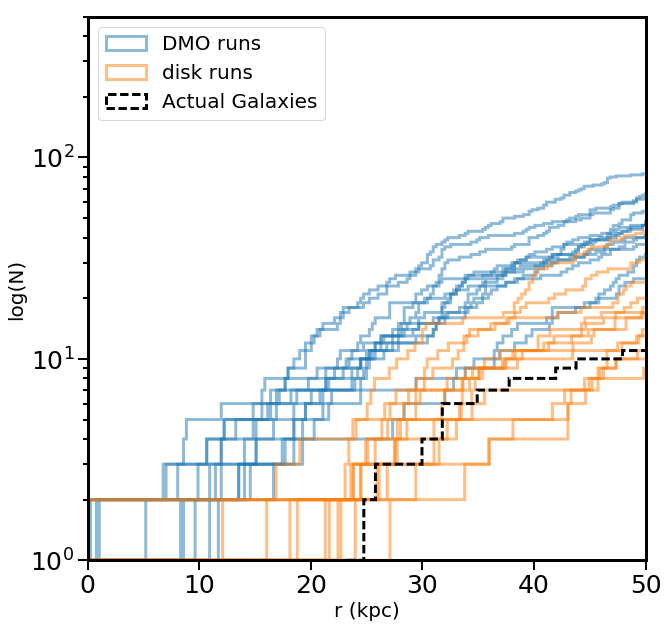

In [10]:
n_files = len(os.listdir('../initial_test_with_ELVIS/Tyler_Data/'))

all_hist_matrix = np.zeros((n_files,1000)) 

n_iter = 0

plt.figure(1,(10,10))
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)
plt.xlim([0.0,50.0])
plt.ylim([1.0,500.0])
plt.xlabel('r (kpc)',fontsize=20)
plt.ylabel('log(N)',fontsize=20)
plt.yscale('log')

for data_file in os.listdir('../initial_test_with_ELVIS/Tyler_Data/'):
    f_halos = h5py.File('../initial_test_with_ELVIS//Tyler_Data/'+data_file)
    halo_name = data_file.split('_')[2]
    #print halo_name
    Data_M = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Vmax'][:]
    Data_Mass = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Mvir'][:]/h
    Data_cens = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Center'][:]*1000.0/h
    Data_X = Data_cens[:,0]
    Data_Y = Data_cens[:,1]
    Data_Z = Data_cens[:,2]
    Data_Rvir = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Rvir'][:]/h

    Vmax_mask = (Data_M>8.0)

    Data_cens_cut = Data_cens[Vmax_mask]
    Data_X_cut = Data_X[Vmax_mask]
    Data_Y_cut = Data_Y[Vmax_mask]
    Data_Z_cut = Data_Z[Vmax_mask]
    Data_M_cut = Data_M[Vmax_mask]
    Data_Rvir_cut = Data_Rvir[Vmax_mask]
    
    host_index = np.argmax(Data_M_cut)
    host_cen = Data_cens_cut[host_index]
    
    coord_dist = Data_cens_cut - host_cen
    distances_from_center = np.linalg.norm(coord_dist,axis=1)
    
    all_hist, all_bins = np.histogram(distances_from_center,bins=np.linspace(0.0,R_vir_host,1001))
    
    plt.hist(distances_from_center,bins=np.linspace(0.0,R_vir_host,1001),cumulative=True,histtype='step',linewidth=3,alpha=0.5,color='C0')
    
    all_hist_c = np.cumsum(all_hist)
    all_hist_matrix[n_iter] = all_hist_c
    n_iter += 1

disk_files = len(os.listdir('../initial_test_with_ELVIS/Tyler_disk_data/'))

disk_hist_matrix = np.zeros((disk_files,1000)) 

disk_iter = 0
    
for data_file in os.listdir('../initial_test_with_ELVIS/Tyler_disk_data/'):
    f_halos = np.loadtxt('../initial_test_with_ELVIS/Tyler_disk_data/'+data_file)
    halo_name = re.split('_|\.',str(data_file))[2]
    Data_M = f_halos[:,3]
    Data_X = f_halos[:,0]*1000.0/h
    Data_Y = f_halos[:,1]*1000.0/h
    Data_Z = f_halos[:,2]*1000.0/h
    Data_Rvir = f_halos[:,5]/h
    Data_Mass = f_halos[:,4]/h
    
    M_t = 8.0
    
    Vmax_mask = (Data_M>M_t)
    
    Data_X_cut = Data_X[Vmax_mask]
    Data_Y_cut = Data_Y[Vmax_mask]
    Data_Z_cut = Data_Z[Vmax_mask]
    Data_M_cut = Data_M[Vmax_mask]
    Data_Rvir_cut = Data_Rvir[Vmax_mask]
    Data_cens_cut = np.vstack((Data_X_cut,Data_Y_cut,Data_Z_cut)).T
    
    host_index = np.argmax(Data_M_cut)
    R_vir_host = Data_Rvir_cut[host_index]
    host_cen = np.array([Data_X_cut[host_index],Data_Y_cut[host_index],Data_Z_cut[host_index]])
    
    #print Data_cens_cut
    
    coord_dist = Data_cens_cut - host_cen
    distances_from_center = np.linalg.norm(coord_dist,axis=1)
    
    disk_hist, disk_bins = np.histogram(distances_from_center,bins=np.linspace(0.0,R_vir_host,1001))
    plt.hist(distances_from_center,bins=np.linspace(0.0,R_vir_host,1001),cumulative=True,histtype='step',linewidth=3,alpha=0.5,color='C1')
    disk_hist_c = np.cumsum(disk_hist)
    disk_hist_matrix[disk_iter] = disk_hist_c
    disk_iter += 1
    
r_list = np.linspace(0.0,R_vir_host,1001)
    
r_list_plot = [(r_list[ii]+r_list[ii+1])/2.0 for ii in range(len(r_list)-1)]
min_line = [np.min(all_hist_matrix[:,ii]) for ii in range(len(all_hist_matrix[0]))]
max_line = [np.max(all_hist_matrix[:,ii]) for ii in range(len(all_hist_matrix[0]))]
med_line = [np.mean(all_hist_matrix[:,ii]) for ii in range(len(all_hist_matrix[0]))]

disk_min_line = [np.min(disk_hist_matrix[:,ii]) for ii in range(len(disk_hist_matrix[0]))]
disk_max_line = [np.max(disk_hist_matrix[:,ii]) for ii in range(len(disk_hist_matrix[0]))]
disk_med_line = [np.mean(disk_hist_matrix[:,ii]) for ii in range(len(disk_hist_matrix[0]))]

plt.hist([],cumulative=True,histtype='step',linewidth=3,alpha=0.5,color='C0',label='DMO runs')
plt.hist([],cumulative=True,histtype='step',linewidth=3,alpha=0.5,color='C1',label='disk runs')
plt.hist(gal_dist,bins=np.linspace(0.0,R_vir_host,1000),cumulative=True,histtype='step',linewidth=3,color='k',linestyle='--',label='Actual Galaxies')

plt.legend(loc=2, prop={'size': 20})
#plt.savefig('./initial_figures/all_halos_individual.png',bbox_inches='tight')
plt.show()

In [58]:
def cart2sph(x,y,z):
    XsqPlusYsq = np.square(x) + np.square(y)
    r = np.sqrt(XsqPlusYsq + np.square(z))         # r
    elev = np.arctan2(z,np.sqrt(XsqPlusYsq))       # phi
    az = np.arctan2(y,x)                           # theta
    return r, elev, az

def calc_open_angle(phi_x,the_x,phi_t,the_t):
    return np.arccos(np.cos(phi_t) * np.cos(phi_x) + np.sin(phi_t) * np.sin(phi_x) * np.cos(the_x - the_t))

def calc_corr_factors(Data_X, Data_Y, Data_Z, Data_M, Data_Rvir, MW, Andr, pnts=100):
    # Rvir converted in Mpc (was kpc) 
    # In order to ignore this I think I just need to set this to zero
    #RO2 = Data_Rvir[Andr]/1000.
    
    DES_cone_len = 1.0 #Satellite[lstn][5]/1000.
    SDSS_cone_len = 1.0 #Satellite[lstn][4]/1000.  #t2 3

    DES_cone_size = 0.7259
    SDSS_coneS_size = 0.7259  #t2
    SDSS_coneB_size = 0.9929   #t3

    #corr_factors = np.zeros((len(data_files),pnts))
    #count_mas = np.zeros((len(data_files),pnts))

    radius_bins = np.linspace(0.0,0.1,101)

    h = 0.6751
    
    RO2 = 0.0
    
    # in Mpc
    z0_cens = np.vstack([Data_X,Data_Y,Data_Z]).T
    pair_dist = z0_cens[Andr] - z0_cens[MW]   # First two are the hosts (M31 & MW)
    coord_dist = z0_cens[2:] - z0_cens[MW]
    
    dis_g = np.linalg.norm(pair_dist)
    distances_from_center = np.linalg.norm(coord_dist,axis=1)[newaxis]
    
    angle_BG = np.arctan(RO2/dis_g)
    
    _, phi_x, the_x = cart2sph(coord_dist[:,0],coord_dist[:,1],coord_dist[:,2])
    _, phi_t, the_t = cart2sph(-pair_dist[0],-pair_dist[1],-pair_dist[2])

    ang_dis = calc_open_angle(phi_x,the_x,phi_t,the_t)

    Andr_gal = ang_dis <= angle_BG # Mask things that are in the same area as Andr.
    Andr_gal = Andr_gal[np.newaxis].T & np.ones(pnts,dtype = 'bool') # Make into N x pnts matrix

    #random
    #np.random.seed(777)
    u = np.random.uniform(0,1,pnts)
    v = np.random.uniform(0,1,pnts)

    the_t = 2. * np.pi * u
    phi_t = np.arccos(2. * v - 1)

    the_t2 = the_t - 0.09
    phi_t2 = phi_t + 1.18
    the_t3 = the_t + 3.1
    phi_t3 = phi_t + 1.72

    the_t2[ the_t2 < 0 ] += 2. * np.pi
    phi_t2[ phi_t2 > np.pi ] -= np.pi
    the_t3[ the_t3 > 2*np.pi ] -= 2*np.pi
    phi_t3[ phi_t3 > np.pi ] -= np.pi

    s = cart2sph(coord_dist[:,0],coord_dist[:,1],coord_dist[:,2])

    phi_x = (s[1])[np.newaxis].T
    the_x = (s[2])[np.newaxis].T
    r = s[0]

    dis = calc_open_angle(phi_x,the_x,phi_t,the_t)
    dis2 = calc_open_angle(phi_x,the_x,phi_t2,the_t2)
    dis3 = calc_open_angle(phi_x,the_x,phi_t3,the_t3)

    r_msk = (r[np.newaxis].T < np.ones(pnts)) & (~Andr_gal)

    r_SDSS = (r[np.newaxis].T < np.ones(pnts) * SDSS_cone_len) & r_msk
    s_SDSS = (dis2 <= SDSS_coneS_size) & r_SDSS
    b_SDSS = (dis3 <= SDSS_coneB_size) & r_SDSS

    print 'shape of angle sdss: '
    print shape(s_SDSS)
    
    print 'shape of angle sdss: '
    print shape(r_SDSS)
    
    in_SDSS = s_SDSS | b_SDSS
    in_DES = (r[np.newaxis].T < np.ones(pnts) * DES_cone_len) & (dis <= DES_cone_size) & r_msk

    in_cones = in_SDSS | in_DES
    
    print 'shape of in cones: '
    print shape(in_cones)
    print in_cones
    
    #okay I believe if I just apply the below line mask to a matrix that is just the 
    #radii of each subhalo array stacked in a matrix 100 times.
    
    #for whatever reason the masked array doesn't really seem to work, and I really can't figure out why
    #so what I'm going to do is loop through each mask (weak) and then just go ahead and bin it up in a 
    #histogram since otherwise the different masks will lead to 
    
    stacked_distance_array_fast = np.broadcast_to(distances_from_center.T,(len(distances_from_center[0]),pnts))
    stacked_mass_array_fast = np.broadcast_to(Data_M.T,(len(Data_M),pnts))
    
    #note: the below line "works" but it gives a 1d array of all the values that pass ANY of the masks (not useful)
    #all_dist_in_cones = stacked_distance_array_fast[in_cones]
    
    #This doesn't work for reasons that escape me, it doesn't mask ANY values
    #distances_within_cones = np.ma.MaskedArray(stacked_distance_array_fast, mask = in_cones)
    
    #The below works but it uses a loop
    
    histogram_matrix = np.zeros((pnts,len(radius_bins)-1))
    
    for ii in range(len(stacked_distance_array_fast[0])):
        #pull out each individual mask
        indiv_mask = in_cones[:,ii]
        #pull out each of the distance arrays (note: I could just use the distances as in always using the
        #distances_from_center array, but I matricized it in case I ever figure out how to do this without
        #a loop)
        indiv_dist = stacked_distance_array_fast[:,ii]
        #indiv_mass = 
        
        halos_within_cone = indiv_dist[indiv_mask]
        
        #now lets bin it with a histogram
        
        hist, bins = np.histogram(halos_within_cone,bins=radius_bins)
        histogram_matrix[ii] = np.cumsum(hist)
    
    #print len(masking_test)
    #print len(stacked_distance_array_fast[:,0][in_cones[:,0]])
    
    count_mas = np.sum(in_cones[Data_M[2:] >= M_t], axis = 0 ) * 1.
    count_tot = np.sum(r_msk[Data_M[2:] >= M_t], axis = 0 ) * 1.
    
    #print shape(in_cones)
    #print shape(stacked_distance_array_fast)
    #print shape(distances_within_cones)
    
    return histogram_matrix

In [59]:
for data_file in os.listdir('../../initial_test_with_ELVIS/Tyler_Data/'):
    f_halos = h5py.File('../../initial_test_with_ELVIS/Tyler_Data/'+data_file)
    halo_name = data_file.split('_')[2]
    print halo_name
    Data_M = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Vmax'][:]
    Data_Mass = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Mvir'][:]/h
    Data_cens = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Center'][:]/h
    Data_X = Data_cens[:,0]
    Data_Y = Data_cens[:,1]
    Data_Z = Data_cens[:,2]
    Data_Rvir = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Rvir'][:]/h
    
    M_t = 8.0
    
    Vmax_mask = (Data_M>8.0)
    
    Data_X_cut = Data_X[Vmax_mask]
    Data_Y_cut = Data_Y[Vmax_mask]
    Data_Z_cut = Data_Z[Vmax_mask]
    Data_M_cut = Data_M[Vmax_mask]
    Data_Rvir_cut = Data_Rvir[Vmax_mask]
    
    host_index = np.argmax(Data_M_cut)
    R_vir_host = Data_Rvir_cut[host_index]
    
    Andr = 0
    MW = host_index

    hist_matrix = calc_corr_factors(Data_X_cut, Data_Y_cut, Data_Z_cut, Data_M_cut, Data_Rvir_cut, pnts, MW, Andr)
    
    #hist_matrix = calc_corr_factors(Data_X, Data_Y, Data_Z, Data_M, Data_Rvir, pnts, MW, Andr)

    plot_bins = [(radius_bins[ii]+radius_bins[ii+1])*1000.0/2.0 for ii in range(len(radius_bins)-1)]

    min_line = [np.min(hist_matrix[:,ii]) for ii in range(len(hist_matrix[0]))]
    max_line = [np.max(hist_matrix[:,ii]) for ii in range(len(hist_matrix[0]))]
    med_line = [np.mean(hist_matrix[:,ii]) for ii in range(len(hist_matrix[0]))]

    hl_line = [high_low_limit(hist_matrix[:,ii],0.68) for ii in range(len(hist_matrix[0]))]
    
    low_line = [xx[0] for xx in hl_line]
    high_line = [xx[1] for xx in hl_line]
    
    plot_top = max_line[-1]
    
    #print distances_within_cones[:,0], stacked_distance_array_fast[:,0]

    f_dat = np.loadtxt('../Sats_data.csv',delimiter=',',dtype=object)
    gal_dist = np.asarray([float(xx) for xx in f_dat[:,1]])
    gal_mass = np.asarray([float(xx) for xx in f_dat[:,2]])

    large_gal_mask = (gal_mass>1.0e4)&(gal_dist<R_vir_host)

    large_gal_dist = gal_dist[large_gal_mask]
    #print large_gal_dist

    plt.figure(1,(10,10))
    rc('axes',linewidth=3)
    plt.yticks(fontsize = 25)
    plt.xticks(fontsize = 25)
    plt.tick_params(which='minor',width=2,length=5)
    plt.tick_params(which='major',width=2,length=10)
    plt.xlim([0.0,50.0])
    plt.ylim([0.8,200.0])
    plt.xlabel('r (kpc)',fontsize=20)
    plt.ylabel('log(N)',fontsize=20)
    plt.yscale('log')
    
    plt.text(5.0,130.0,halo_name+' (No disk)',fontsize=20)
    plt.text(5.0,100.0,'Halos: $V_{max}$ > 8 $kms^{-1}$',fontsize=20)
    plt.text(5.0,80.0,'Galaxies: $M_{star}$ > $10^4$ $M_{\odot}$',fontsize=20)
    
    plt.hist(gal_dist,bins=np.linspace(0.0,R_vir_host,1000),cumulative=True,histtype='step',linewidth=3)

    plt.fill_between(plot_bins,low_line,high_line,color='C2',alpha=0.5)
    plt.plot(plot_bins,med_line,color='C2')

    #plt.yscale('log')
    #plt.legend(loc=1, prop={'size': 20})
    #plt.savefig('./initial_figures/non_disk_'+str(halo_name)+'.png',bbox_inches='tight')
    plt.show()

1107
shape of angle sdss: 
(3980, 100)
shape of angle sdss: 
(3980, 100)
shape of in cones: 
(3980, 100)
[[False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]
 ..., 
 [ True False False ...,  True  True  True]
 [False False False ...,  True False  True]
 [False False False ...,  True False False]]


ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (3982,) and requested shape (3982,100)

1107


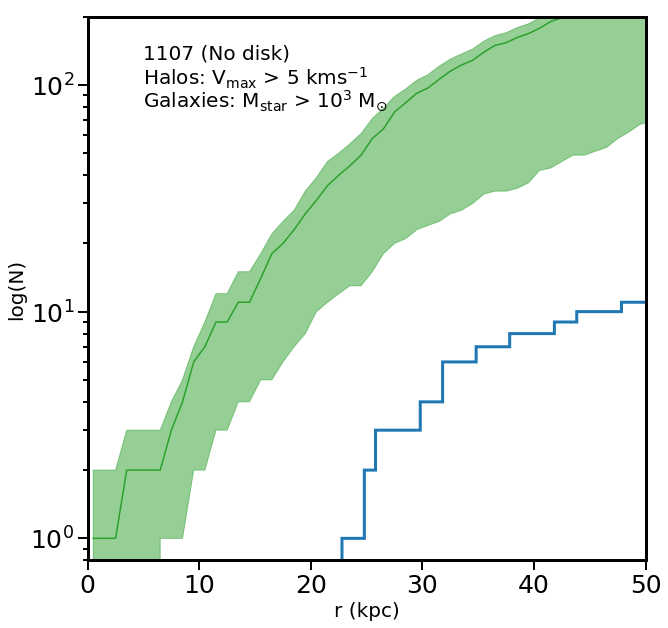

1245


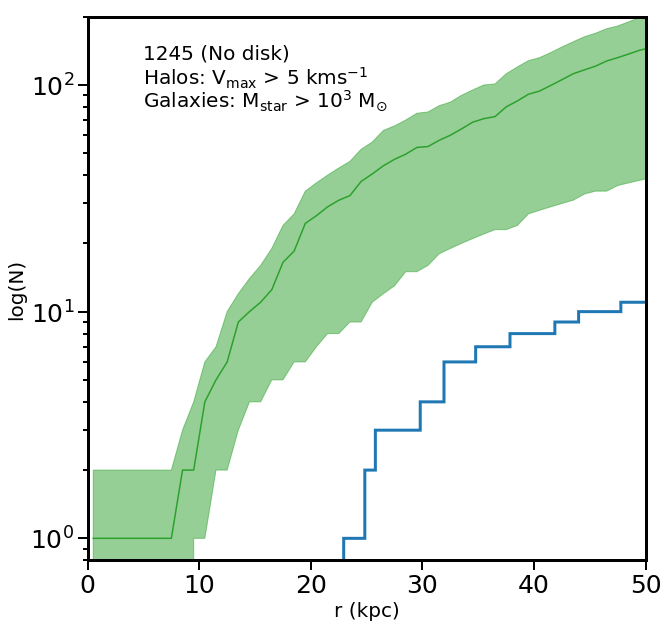

1386


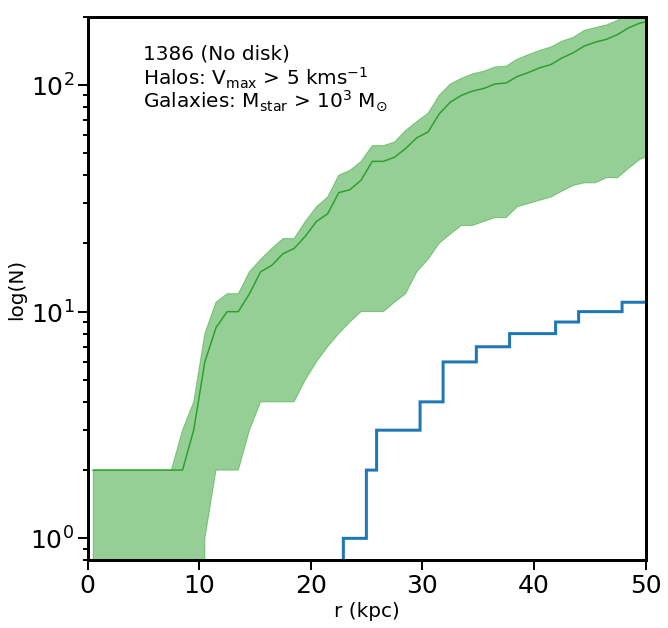

493


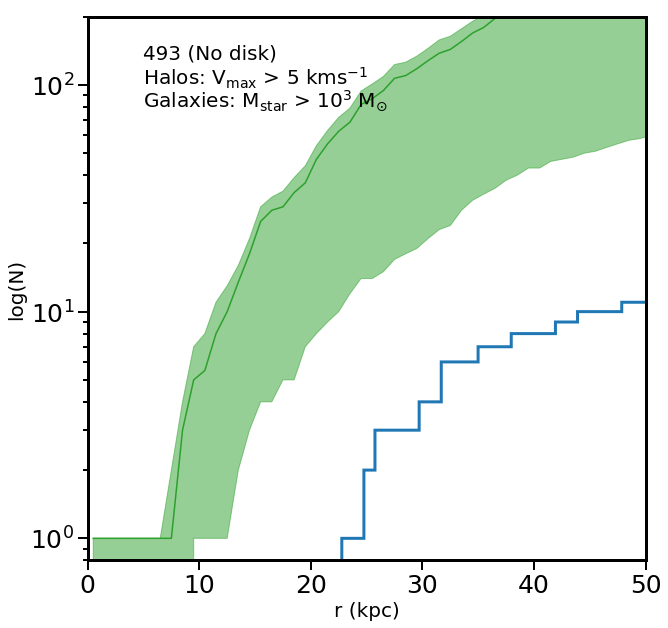

539


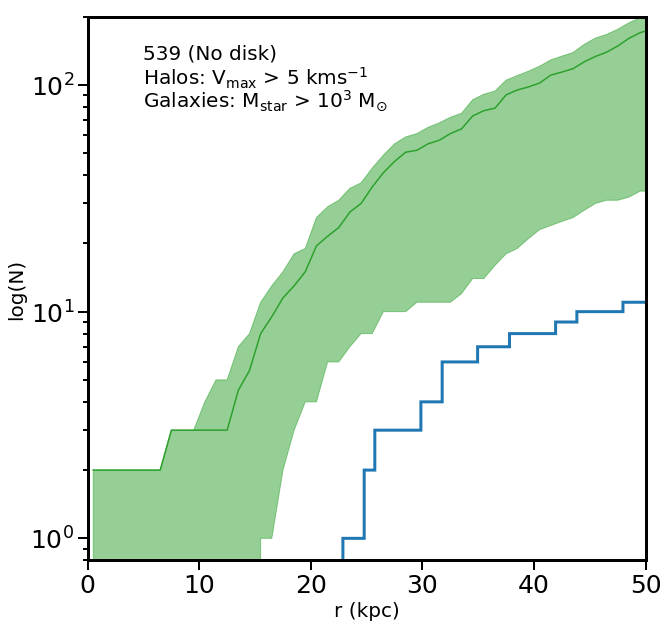

609


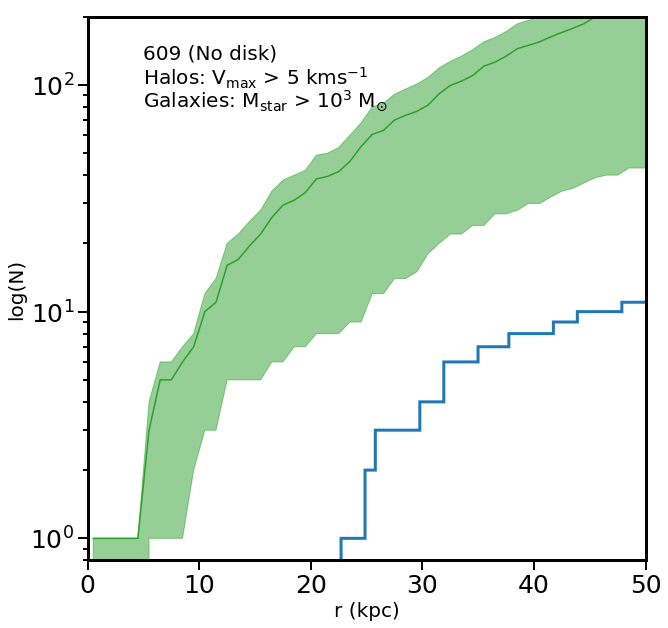

694


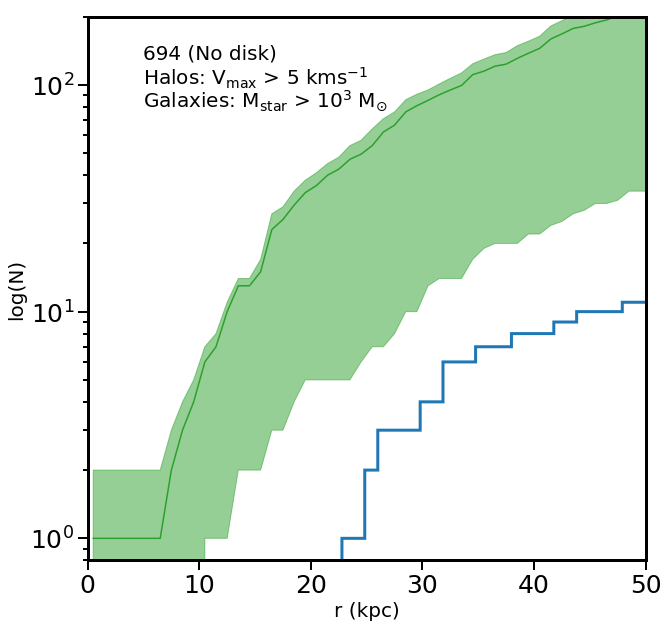

795


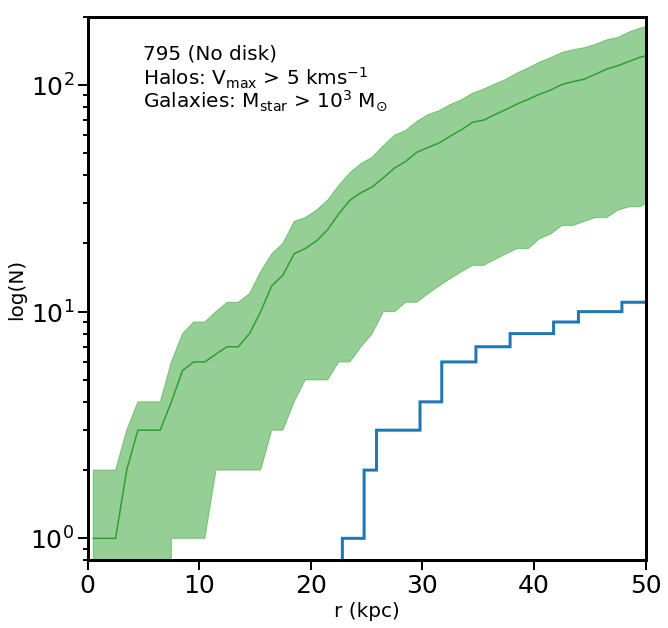

833


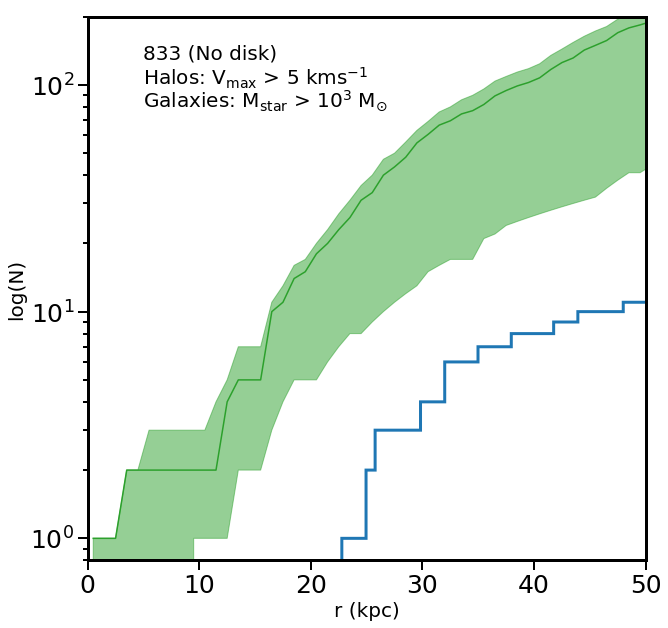

848


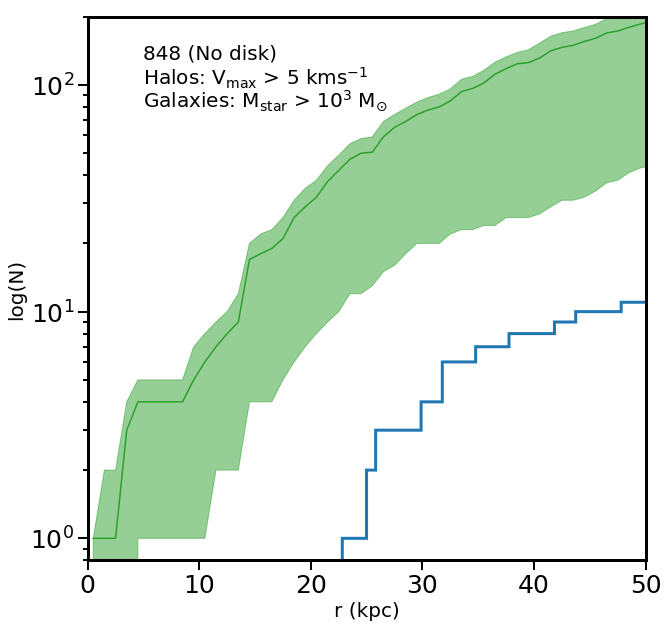

879


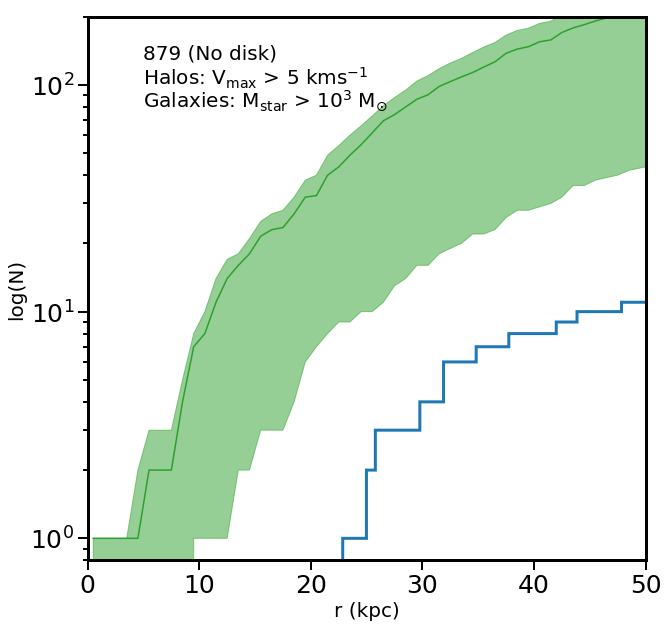

988


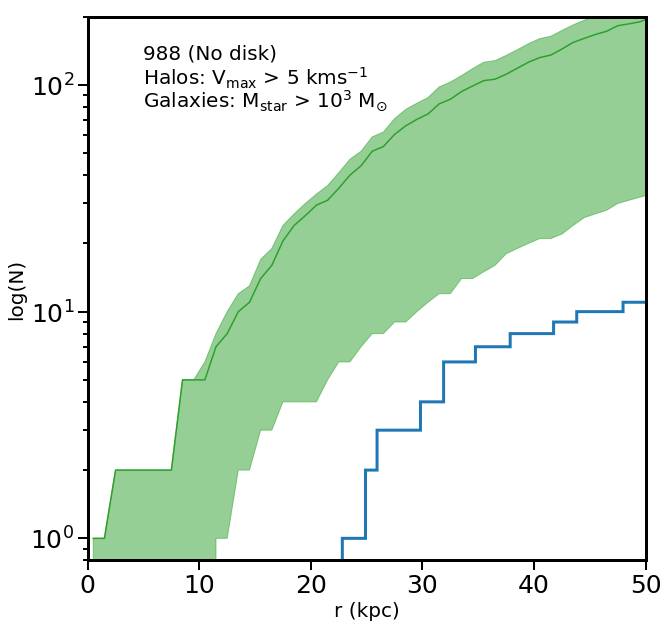

In [20]:
for data_file in os.listdir('../initial_test_with_ELVIS/Tyler_Data/'):
    f_halos = h5py.File('../initial_test_with_ELVIS/Tyler_Data/'+data_file)
    halo_name = data_file.split('_')[2]
    print halo_name
    Data_M = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Vmax'][:]
    Data_Mass = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Mvir'][:]/h
    Data_cens = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Center'][:]/h
    Data_X = Data_cens[:,0]
    Data_Y = Data_cens[:,1]
    Data_Z = Data_cens[:,2]
    Data_Rvir = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Rvir'][:]/h
    
    M_t = 5.0
    
    Vmax_mask = (Data_M>M_t)
    
    Data_X_cut = Data_X[Vmax_mask]
    Data_Y_cut = Data_Y[Vmax_mask]
    Data_Z_cut = Data_Z[Vmax_mask]
    Data_M_cut = Data_M[Vmax_mask]
    Data_Rvir_cut = Data_Rvir[Vmax_mask]
    
    host_index = np.argmax(Data_M_cut)
    R_vir_host = Data_Rvir_cut[host_index]
    
    Andr = 0
    MW = host_index

    hist_matrix = calc_corr_factors(Data_X_cut, Data_Y_cut, Data_Z_cut, Data_M_cut, Data_Rvir_cut, pnts, MW, Andr)
    
    #hist_matrix = calc_corr_factors(Data_X, Data_Y, Data_Z, Data_M, Data_Rvir, pnts, MW, Andr)

    plot_bins = [(radius_bins[ii]+radius_bins[ii+1])*1000.0/2.0 for ii in range(len(radius_bins)-1)]

    min_line = [np.min(hist_matrix[:,ii]) for ii in range(len(hist_matrix[0]))]
    max_line = [np.max(hist_matrix[:,ii]) for ii in range(len(hist_matrix[0]))]
    med_line = [np.median(hist_matrix[:,ii]) for ii in range(len(hist_matrix[0]))]
    
    hl_line = [high_low_limit(hist_matrix[:,ii],0.68) for ii in range(len(hist_matrix[0]))]
    
    low_line = [xx[0] for xx in hl_line]
    high_line = [xx[1] for xx in hl_line]
    
    #print hl_line[0]

    plot_top = max_line[-1]
    
    #print distances_within_cones[:,0], stacked_distance_array_fast[:,0]

    f_dat = np.loadtxt('../Sats_data.csv',delimiter=',',dtype=object)
    gal_dist = np.asarray([float(xx) for xx in f_dat[:,1]])
    gal_mass = np.asarray([float(xx) for xx in f_dat[:,2]])

    large_gal_mask = (gal_mass>1.0e3)&(gal_dist<R_vir_host)

    large_gal_dist = gal_dist[large_gal_mask]
    #print large_gal_dist

    plt.figure(1,(10,10))
    rc('axes',linewidth=3)
    plt.yticks(fontsize = 25)
    plt.xticks(fontsize = 25)
    plt.tick_params(which='minor',width=2,length=5)
    plt.tick_params(which='major',width=2,length=10)
    plt.xlim([0.0,50.0])
    plt.ylim([0.8,200.0])
    plt.xlabel('r (kpc)',fontsize=20)
    plt.ylabel('log(N)',fontsize=20)
    plt.yscale('log')

    plt.text(5.0,130.0,halo_name+' (No disk)',fontsize=20)
    plt.text(5.0,100.0,'Halos: $V_{max}$ > 5 $kms^{-1}$',fontsize=20)
    plt.text(5.0,80.0,'Galaxies: $M_{star}$ > $10^3$ $M_{\odot}$',fontsize=20)
    
    plt.hist(gal_dist,bins=np.linspace(0.0,R_vir_host,1000),cumulative=True,histtype='step',linewidth=3)

    plt.fill_between(plot_bins,low_line,high_line,color='C2',alpha=0.5)
    plt.plot(plot_bins,med_line,color='C2')

    #plt.yscale('log')
    #plt.legend(loc=1, prop={'size': 20})
    #plt.savefig('./initial_figures/non_disk_'+str(halo_name)+'_small.png',bbox_inches='tight')
    plt.show()

178.599808
238367 3795


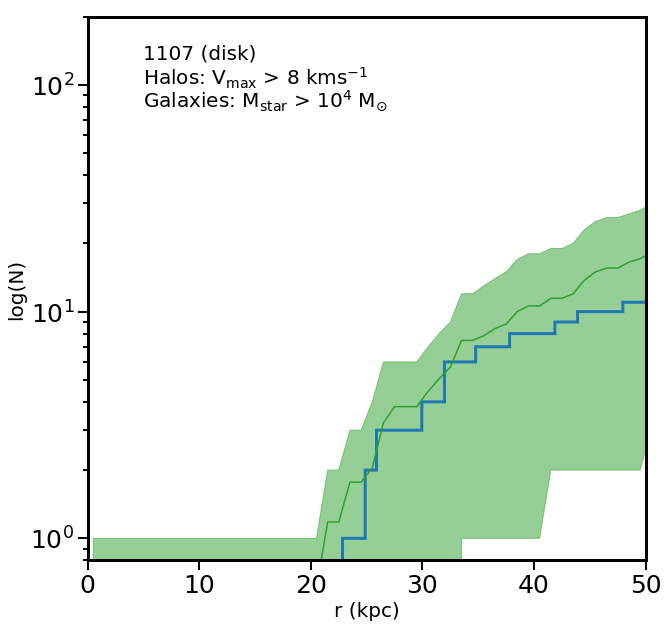

172.927429
101216 1653


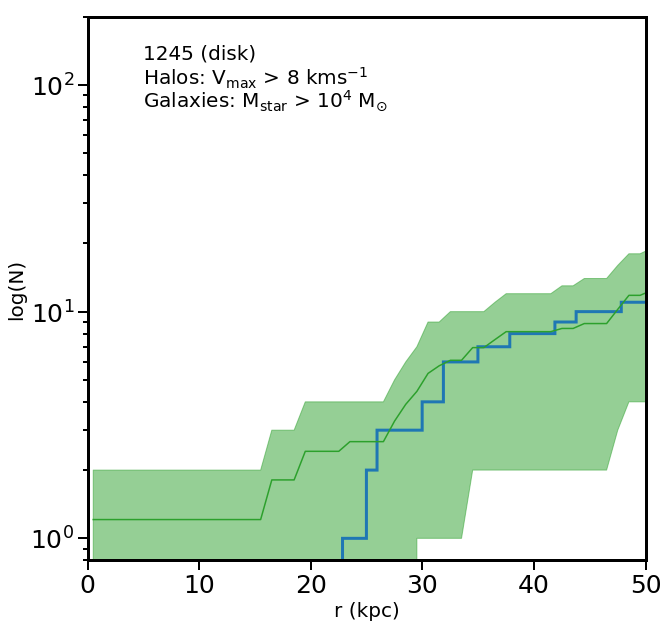

163.505722
115092 1697


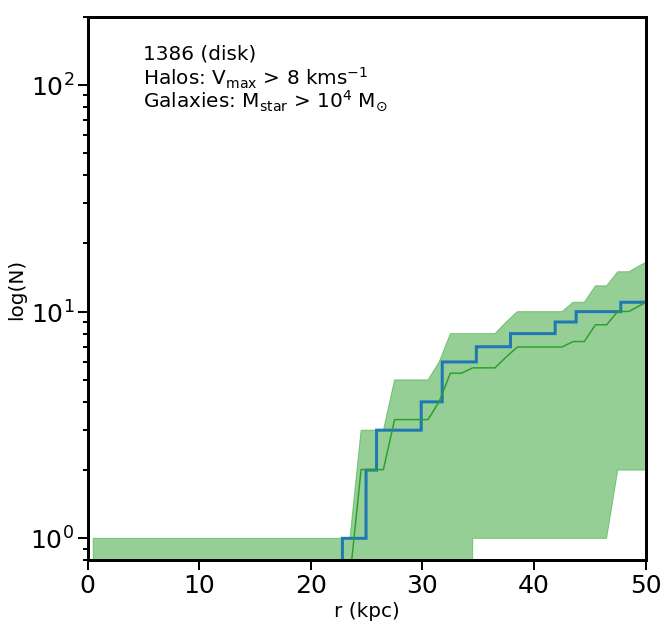

202.228943
179809 2921


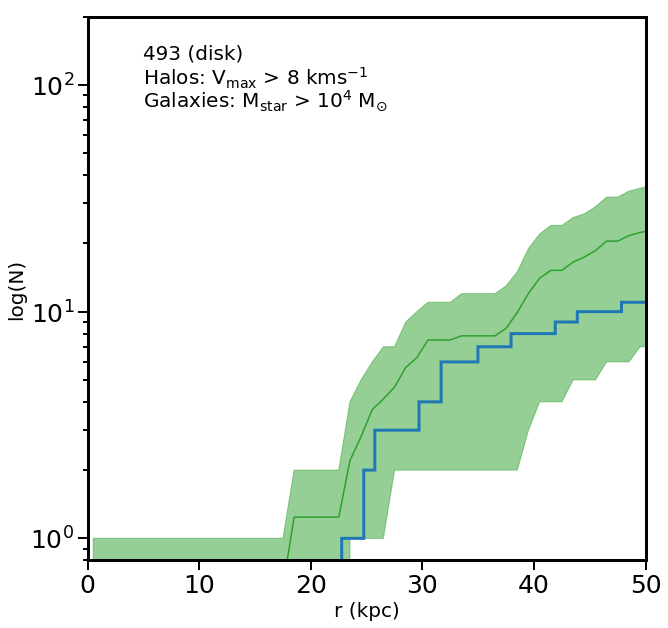

205.71376
171282 2656


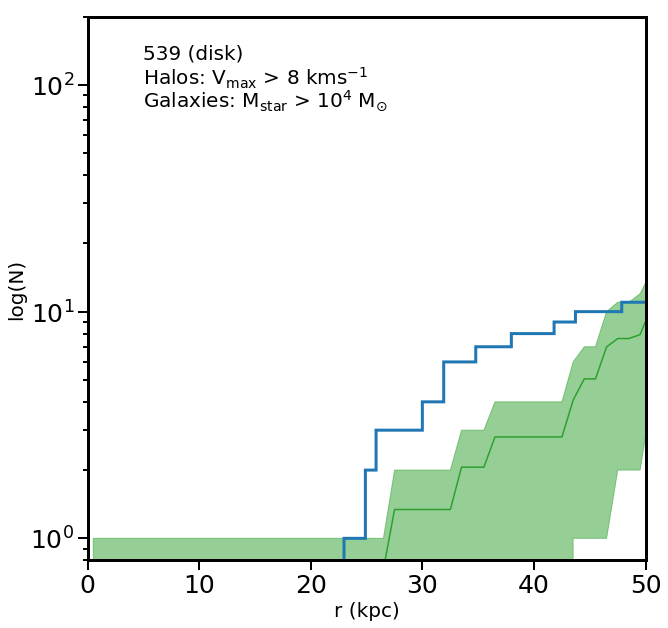

195.583115
194802 3016


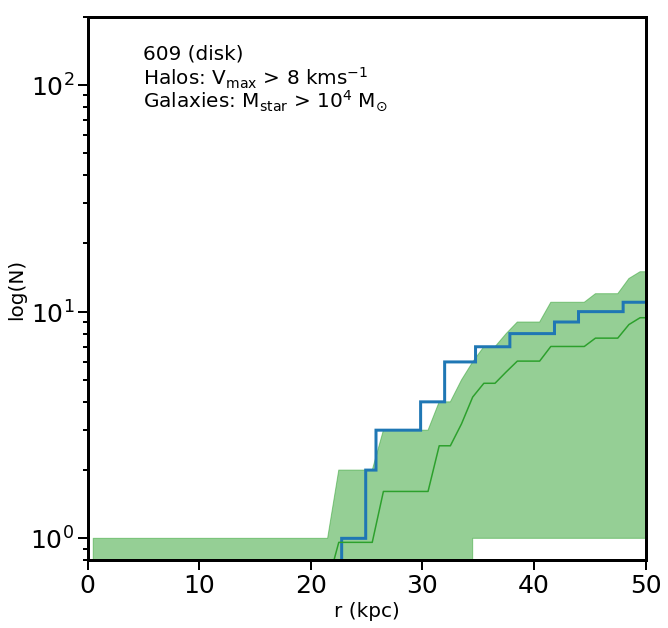

189.467468
229949 3519


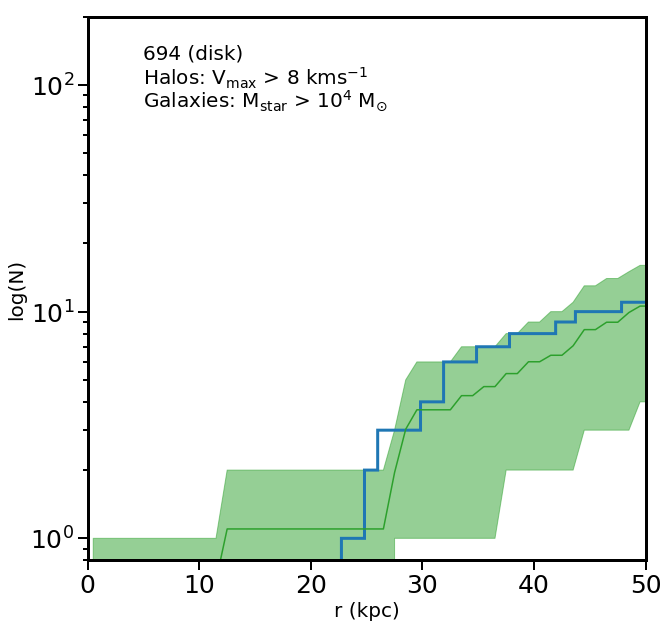

187.713303
154345 2399


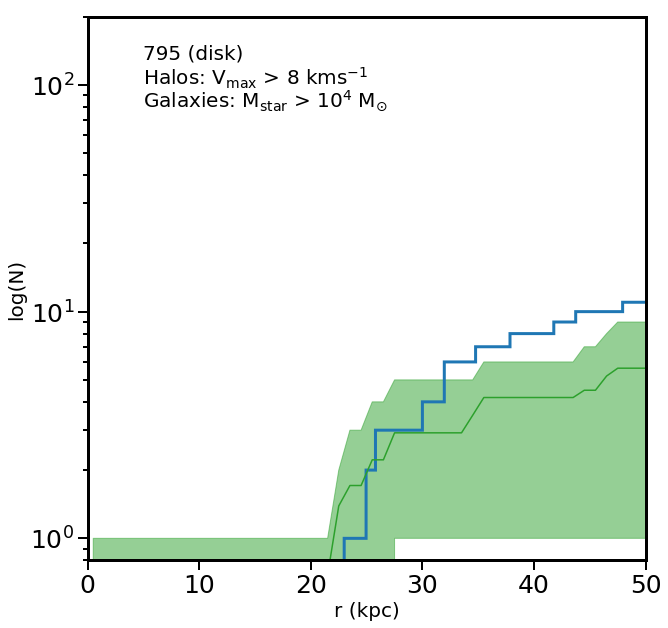

165.507858
160314 2632


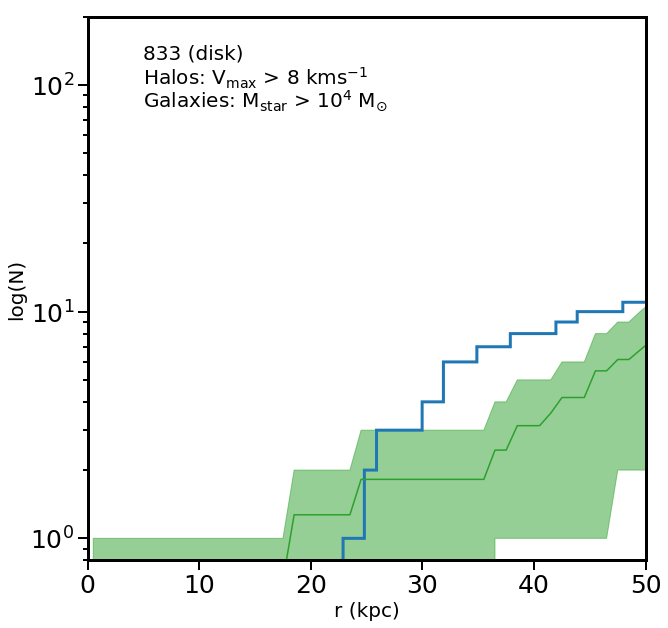

202.330902
128496 1913


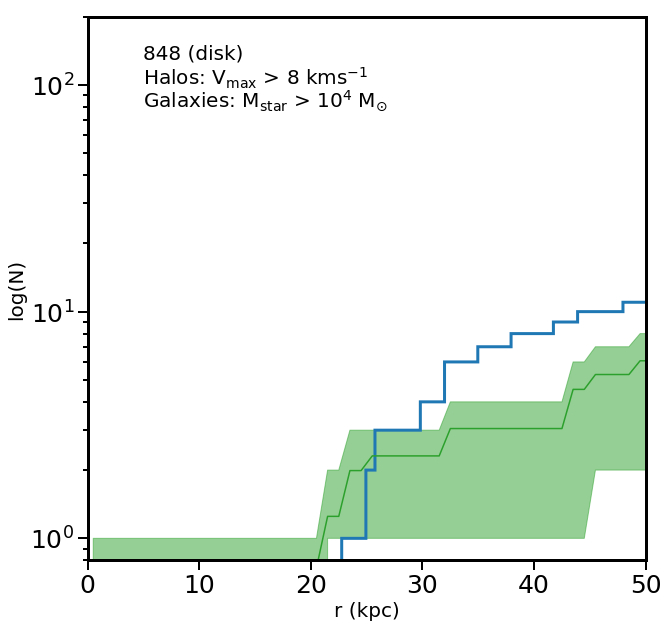

180.47937
134773 1918


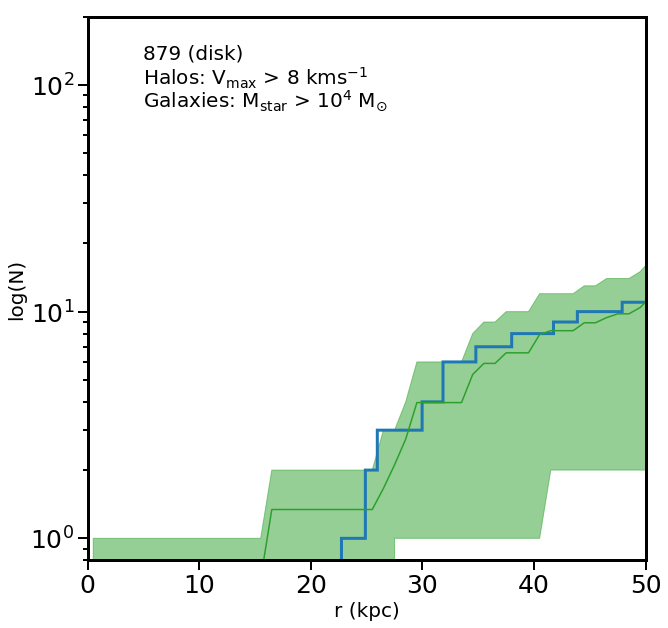

171.383865
106007 1658


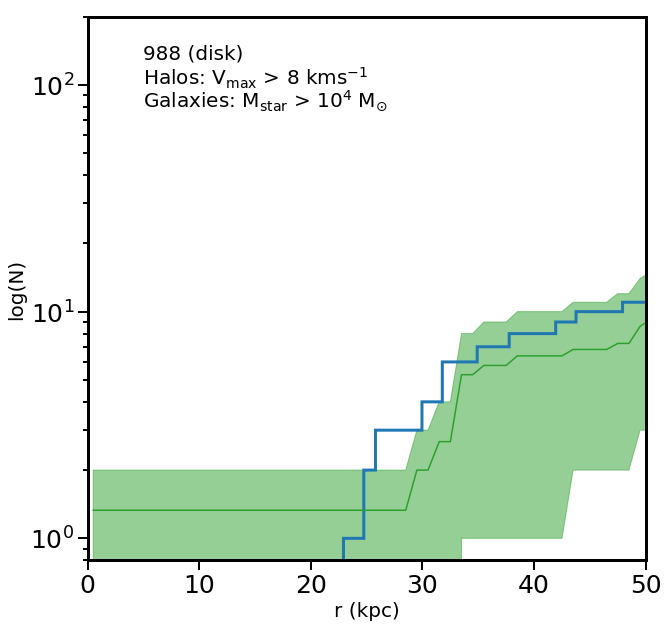

In [21]:
for data_file in os.listdir('../initial_test_with_ELVIS/Tyler_disk_data/'):
    f_halos = np.loadtxt('../initial_test_with_ELVIS/Tyler_disk_data/'+data_file)
    halo_name = re.split('_|\.',str(data_file))[2]
    Data_M = f_halos[:,3]
    Data_X = f_halos[:,0]/h
    Data_Y = f_halos[:,1]/h
    Data_Z = f_halos[:,2]/h
    Data_Rvir = f_halos[:,5]/h
    Data_Mass = f_halos[:,4]/h
    
    M_t = 8.0
    
    Vmax_mask = (Data_M>8.0)
    
    Data_X_cut = Data_X[Vmax_mask]
    Data_Y_cut = Data_Y[Vmax_mask]
    Data_Z_cut = Data_Z[Vmax_mask]
    Data_M_cut = Data_M[Vmax_mask]
    Data_Rvir_cut = Data_Rvir[Vmax_mask]
    
    host_index = np.argmax(Data_M_cut)
    print Data_M_cut[host_index]
    R_vir_host = Data_Rvir_cut[host_index]
    
    Andr = 0
    MW = host_index
    
    print len(Data_X), len(Data_X_cut) 

    hist_matrix = calc_corr_factors(Data_X_cut, Data_Y_cut, Data_Z_cut, Data_M_cut, Data_Rvir_cut, pnts, MW, Andr)
    
    #hist_matrix = calc_corr_factors(Data_X, Data_Y, Data_Z, Data_M, Data_Rvir, pnts, MW, Andr)

    plot_bins = [(radius_bins[ii]+radius_bins[ii+1])*1000.0/2.0 for ii in range(len(radius_bins)-1)]

    min_line = [np.min(hist_matrix[:,ii]) for ii in range(len(hist_matrix[0]))]
    max_line = [np.max(hist_matrix[:,ii]) for ii in range(len(hist_matrix[0]))]
    med_line = [np.mean(hist_matrix[:,ii]) for ii in range(len(hist_matrix[0]))]
    
    hl_line = [high_low_limit(hist_matrix[:,ii],0.68) for ii in range(len(hist_matrix[0]))]
    
    low_line = [xx[0] for xx in hl_line]
    high_line = [xx[1] for xx in hl_line]

    plot_top = max_line[-1]
    
    #print distances_within_cones[:,0], stacked_distance_array_fast[:,0]

    f_dat = np.loadtxt('../Sats_data.csv',delimiter=',',dtype=object)
    gal_dist = np.asarray([float(xx) for xx in f_dat[:,1]])
    gal_mass = np.asarray([float(xx) for xx in f_dat[:,2]])

    large_gal_mask = (gal_mass>1.0e4)&(gal_dist<R_vir_host)

    large_gal_dist = gal_dist[large_gal_mask]
    #print large_gal_dist

    plt.figure(1,(10,10))
    rc('axes',linewidth=3)
    plt.yticks(fontsize = 25)
    plt.xticks(fontsize = 25)
    plt.tick_params(which='minor',width=2,length=5)
    plt.tick_params(which='major',width=2,length=10)
    plt.xlim([0.0,50.0])
    plt.ylim([0.8,200.0])
    plt.xlabel('r (kpc)',fontsize=20)
    plt.ylabel('log(N)',fontsize=20)
    plt.yscale('log')
    #plt.xscale('log')
    
    plt.text(5.0,130.0,halo_name+' (disk)',fontsize=20)
    plt.text(5.0,100.0,'Halos: $V_{max}$ > 8 $kms^{-1}$',fontsize=20)
    plt.text(5.0,80.0,'Galaxies: $M_{star}$ > $10^4$ $M_{\odot}$',fontsize=20)
    
    plt.hist(gal_dist,bins=np.linspace(0.0,R_vir_host,1000),cumulative=True,histtype='step',linewidth=3)

    plt.fill_between(plot_bins,low_line,high_line,color='C2',alpha=0.5)
    plt.plot(plot_bins,med_line,color='C2')

    #plt.yscale('log')
    #plt.savefig('./initial_figures/disk_'+str(halo_name)+'.png',bbox_inches='tight')
    plt.show()

178.599808
238367 16957


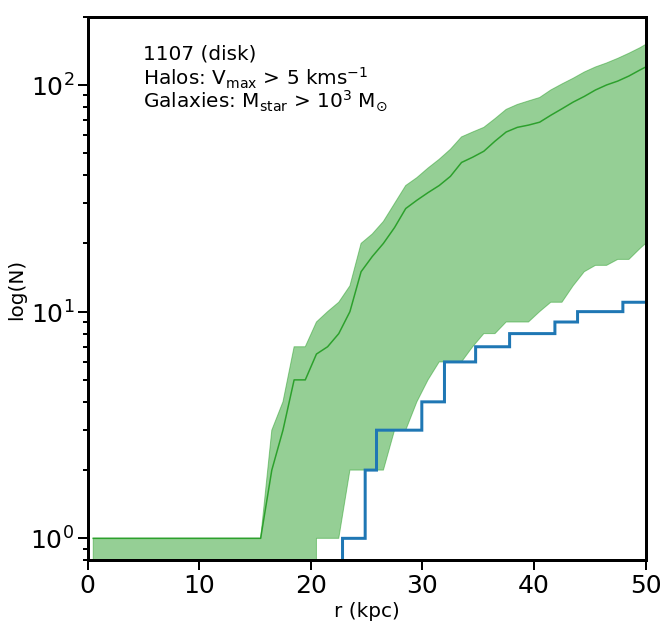

172.927429
101216 7867


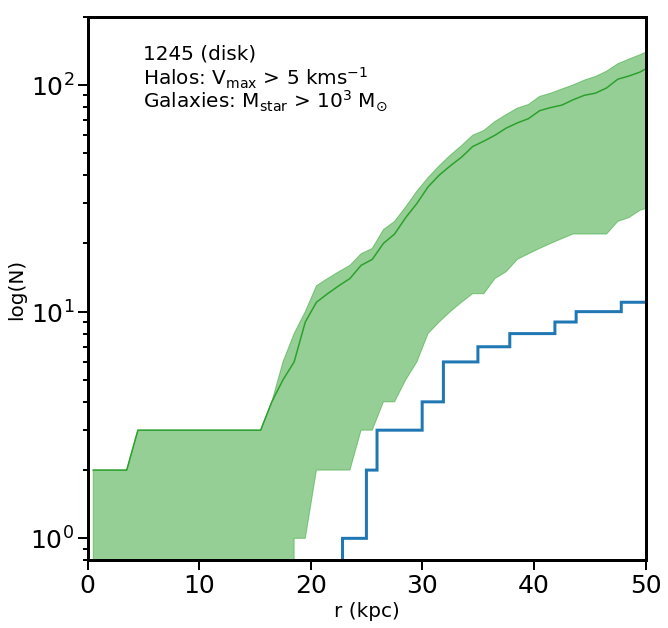

163.505722
115092 8012


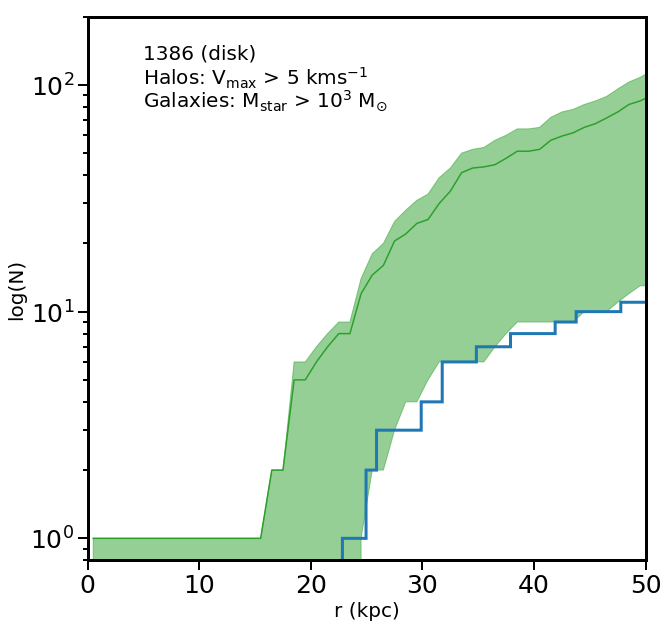

202.228943
179809 14521


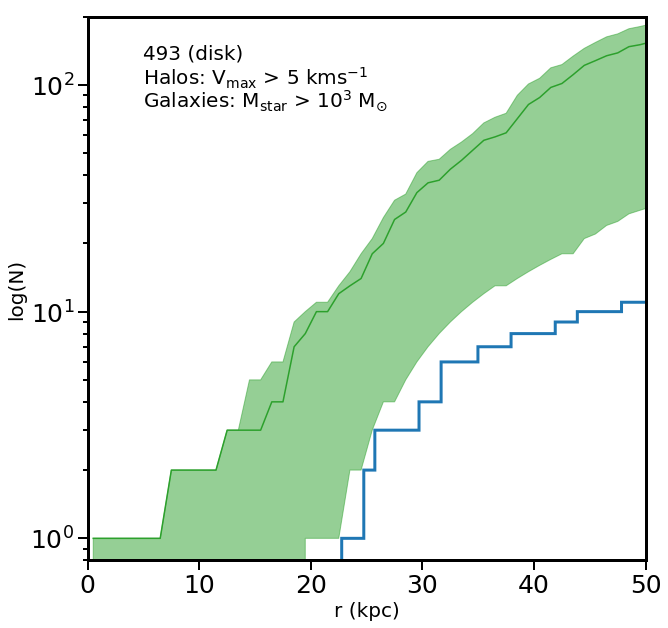

205.71376
171282 12336


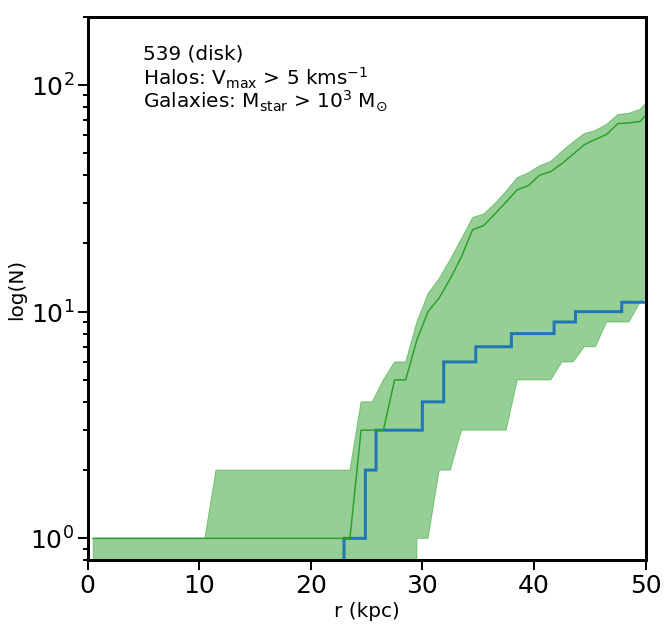

195.583115
194802 14143


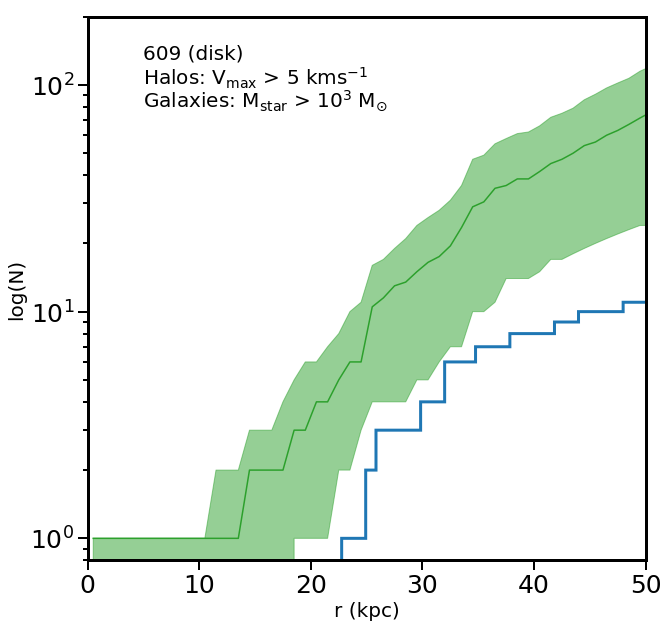

189.467468
229949 15632


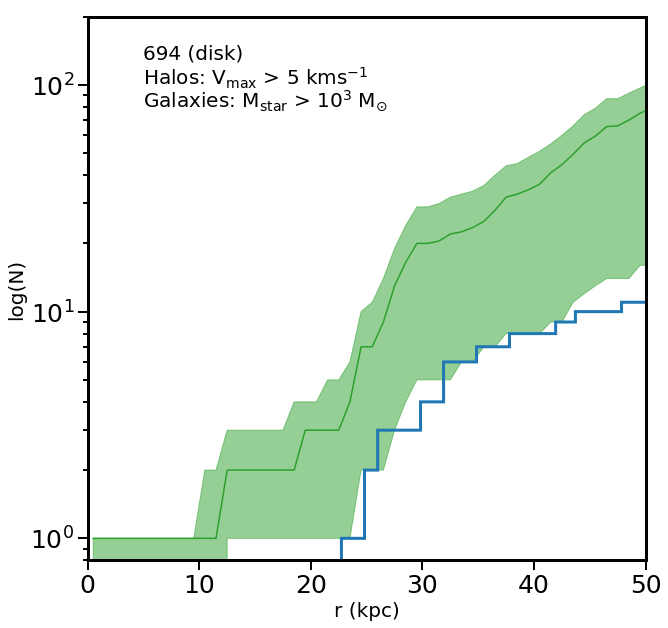

187.713303
154345 11678


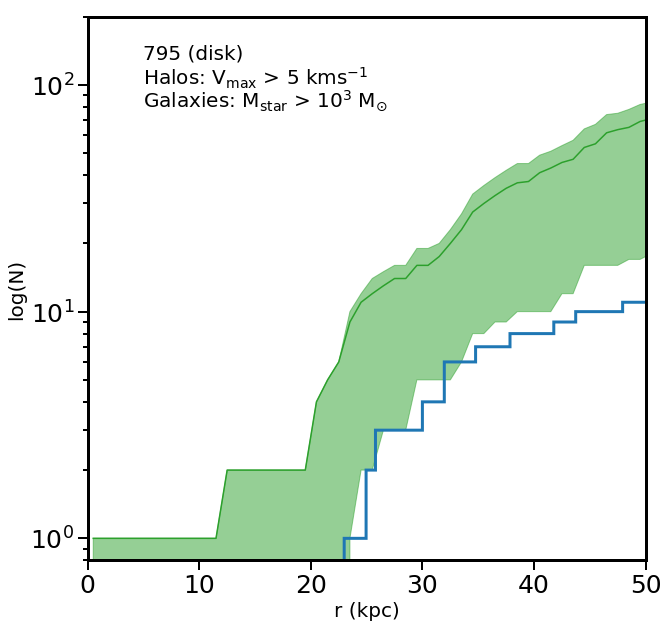

165.507858
160314 11813


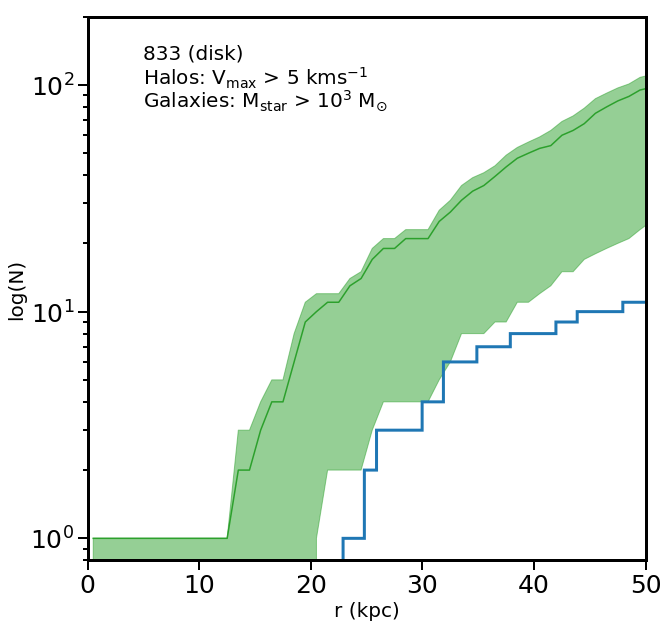

202.330902
128496 9295


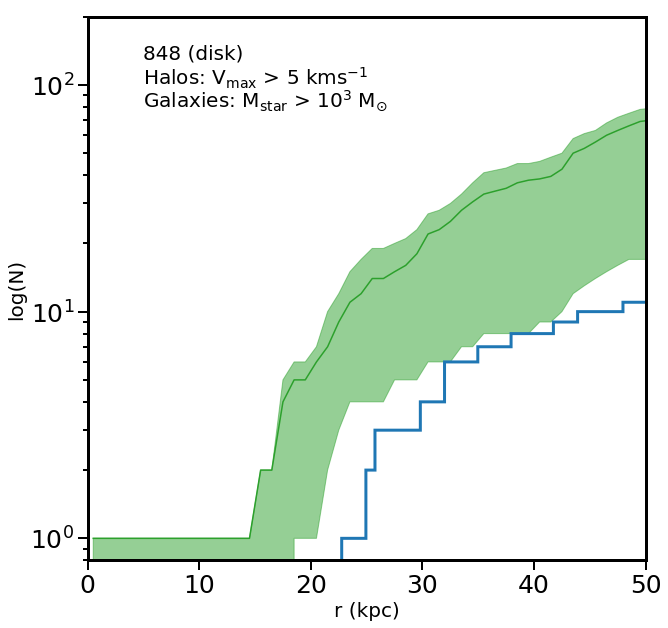

180.47937
134773 9326


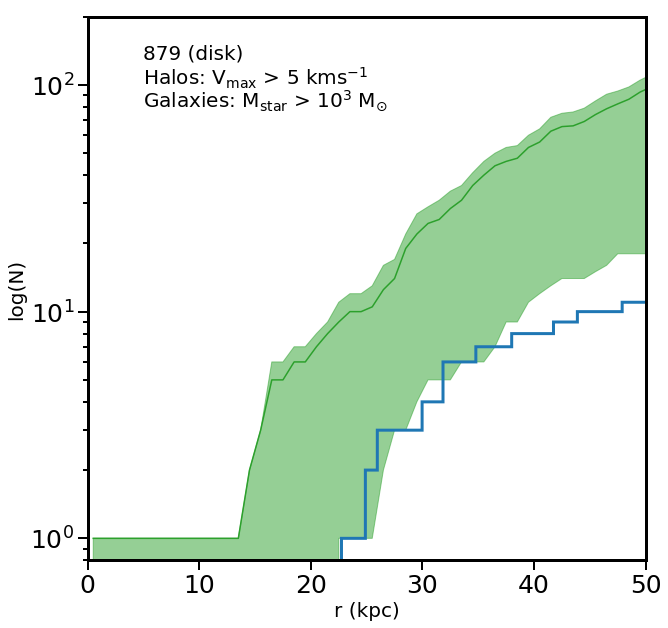

171.383865
106007 7879


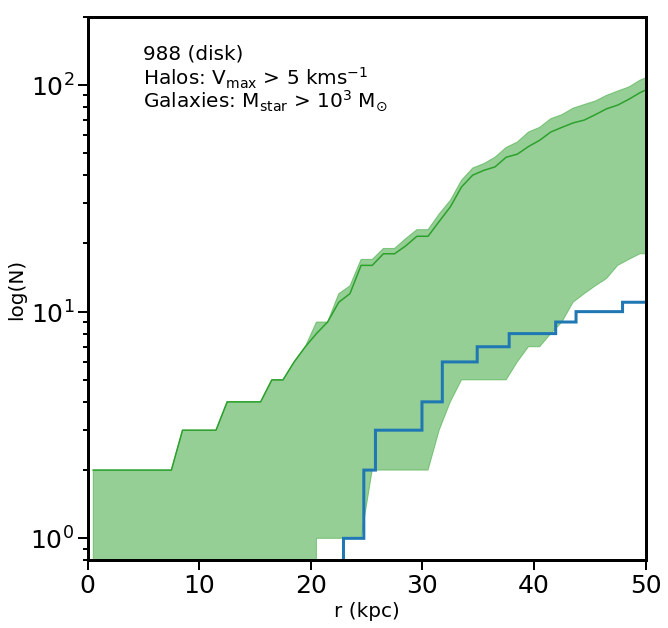

In [22]:
for data_file in os.listdir('../initial_test_with_ELVIS/Tyler_disk_data/'):
    f_halos = np.loadtxt('../initial_test_with_ELVIS/Tyler_disk_data/'+data_file)
    halo_name = re.split('_|\.',str(data_file))[2]
    Data_M = f_halos[:,3]
    Data_X = f_halos[:,0]/h
    Data_Y = f_halos[:,1]/h
    Data_Z = f_halos[:,2]/h
    Data_Rvir = f_halos[:,5]/h
    Data_Mass = f_halos[:,4]/h
    
    M_t = 5.0
    
    Vmax_mask = (Data_M>M_t)
    
    Data_X_cut = Data_X[Vmax_mask]
    Data_Y_cut = Data_Y[Vmax_mask]
    Data_Z_cut = Data_Z[Vmax_mask]
    Data_M_cut = Data_M[Vmax_mask]
    Data_Rvir_cut = Data_Rvir[Vmax_mask]
    
    host_index = np.argmax(Data_M_cut)
    print Data_M_cut[host_index]
    R_vir_host = Data_Rvir_cut[host_index]
    
    Andr = 0
    MW = host_index
    
    print len(Data_X), len(Data_X_cut) 

    hist_matrix = calc_corr_factors(Data_X_cut, Data_Y_cut, Data_Z_cut, Data_M_cut, Data_Rvir_cut, pnts, MW, Andr)
    
    #hist_matrix = calc_corr_factors(Data_X, Data_Y, Data_Z, Data_M, Data_Rvir, pnts, MW, Andr)

    plot_bins = [(radius_bins[ii]+radius_bins[ii+1])*1000.0/2.0 for ii in range(len(radius_bins)-1)]

    min_line = [np.min(hist_matrix[:,ii]) for ii in range(len(hist_matrix[0]))]
    max_line = [np.max(hist_matrix[:,ii]) for ii in range(len(hist_matrix[0]))]
    med_line = [np.median(hist_matrix[:,ii]) for ii in range(len(hist_matrix[0]))]
    
    hl_line = [high_low_limit(hist_matrix[:,ii],0.68) for ii in range(len(hist_matrix[0]))]
    
    low_line = [xx[0] for xx in hl_line]
    high_line = [xx[1] for xx in hl_line]

    plot_top = max_line[-1]
    
    #print distances_within_cones[:,0], stacked_distance_array_fast[:,0]

    f_dat = np.loadtxt('../Sats_data.csv',delimiter=',',dtype=object)
    gal_dist = np.asarray([float(xx) for xx in f_dat[:,1]])
    gal_mass = np.asarray([float(xx) for xx in f_dat[:,2]])

    large_gal_mask = (gal_mass>1.0e3)&(gal_dist<R_vir_host)

    large_gal_dist = gal_dist[large_gal_mask]
    #print large_gal_dist

    plt.figure(1,(10,10))
    rc('axes',linewidth=3)
    plt.yticks(fontsize = 25)
    plt.xticks(fontsize = 25)
    plt.tick_params(which='minor',width=2,length=5)
    plt.tick_params(which='major',width=2,length=10)
    plt.xlim([0.0,50.0])
    plt.ylim([0.8,200.0])
    plt.xlabel('r (kpc)',fontsize=20)
    plt.ylabel('log(N)',fontsize=20)
    plt.yscale('log')
    
    plt.text(5.0,130.0,halo_name+' (disk)',fontsize=20)
    plt.text(5.0,100.0,'Halos: $V_{max}$ > 5 $kms^{-1}$',fontsize=20)
    plt.text(5.0,80.0,'Galaxies: $M_{star}$ > $10^3$ $M_{\odot}$',fontsize=20)
    
    plt.hist(gal_dist,bins=np.linspace(0.0,R_vir_host,1000),cumulative=True,histtype='step',linewidth=3)

    plt.fill_between(plot_bins,low_line,high_line,color='C2',alpha=0.5)
    plt.plot(plot_bins,med_line,color='C2')
    plt.show()

# Compile all halos

1107
1245
(100, 100) (100, 100)
1386
(200, 100) (100, 100)


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:34: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


493
(300, 100) (100, 100)
539
(400, 100) (100, 100)
609
(500, 100) (100, 100)
694
(600, 100) (100, 100)
795
(700, 100) (100, 100)
833
(800, 100) (100, 100)
848
(900, 100) (100, 100)
879
(1000, 100) (100, 100)
988
(1100, 100) (100, 100)
1200
(1200, 100)


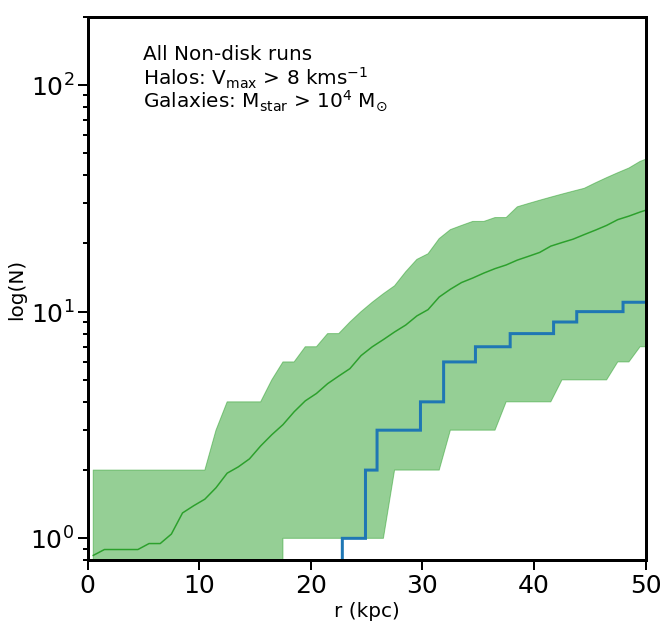

In [33]:
total_len = 0
total_hist = None

for data_file in os.listdir('../initial_test_with_ELVIS/Tyler_Data/'):
    f_halos = h5py.File('../initial_test_with_ELVIS/Tyler_Data/'+data_file)
    halo_name = data_file.split('_')[2]
    print halo_name
    Data_M = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Vmax'][:]
    Data_Mass = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Mvir'][:]/h
    Data_cens = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Center'][:]/h
    Data_X = Data_cens[:,0]
    Data_Y = Data_cens[:,1]
    Data_Z = Data_cens[:,2]
    Data_Rvir = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Rvir'][:]/h
    
    M_t = 8.0
    
    Vmax_mask = (Data_M>8.0)
    
    Data_X_cut = Data_X[Vmax_mask]
    Data_Y_cut = Data_Y[Vmax_mask]
    Data_Z_cut = Data_Z[Vmax_mask]
    Data_M_cut = Data_M[Vmax_mask]
    Data_Rvir_cut = Data_Rvir[Vmax_mask]
    
    host_index = np.argmax(Data_M_cut)
    R_vir_host = Data_Rvir_cut[host_index]
    
    Andr = 0
    MW = host_index

    hist_matrix = calc_corr_factors(Data_X_cut, Data_Y_cut, Data_Z_cut, Data_M_cut, Data_Rvir_cut, pnts, MW, Andr)
        
    if total_hist == None:
        total_hist = hist_matrix
    else:
        print shape(total_hist), shape(hist_matrix)
        total_hist = np.concatenate((total_hist,hist_matrix),axis=0)
    
    total_len += len(hist_matrix)
    
print total_len
print shape(total_hist)
        

plot_bins = [(radius_bins[ii]+radius_bins[ii+1])*1000.0/2.0 for ii in range(len(radius_bins)-1)]

min_line = [np.min(total_hist[:,ii]) for ii in range(len(total_hist[0]))]
max_line = [np.max(total_hist[:,ii]) for ii in range(len(total_hist[0]))]
med_line = [np.mean(total_hist[:,ii]) for ii in range(len(total_hist[0]))]

hl_line = [high_low_limit(total_hist[:,ii],0.68) for ii in range(len(total_hist[0]))]

low_line = [xx[0] for xx in hl_line]
high_line = [xx[1] for xx in hl_line]

plot_top = max_line[-1]

#print distances_within_cones[:,0], stacked_distance_array_fast[:,0]

f_dat = np.loadtxt('../Sats_data.csv',delimiter=',',dtype=object)
gal_dist = np.asarray([float(xx) for xx in f_dat[:,1]])
gal_mass = np.asarray([float(xx) for xx in f_dat[:,2]])

large_gal_mask = (gal_mass>1.0e4)&(gal_dist<R_vir_host)

large_gal_dist = gal_dist[large_gal_mask]
#print large_gal_dist

plt.figure(1,(10,10))
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)
plt.xlim([0.0,50.0])
plt.ylim([0.8,200.0])
plt.xlabel('r (kpc)',fontsize=20)
plt.ylabel('log(N)',fontsize=20)
plt.yscale('log')

plt.text(5.0,130.0,'All Non-disk runs',fontsize=20)
plt.text(5.0,100.0,'Halos: $V_{max}$ > 8 $kms^{-1}$',fontsize=20)
plt.text(5.0,80.0,'Galaxies: $M_{star}$ > $10^4$ $M_{\odot}$',fontsize=20)

plt.hist(gal_dist,bins=np.linspace(0.0,R_vir_host,1000),cumulative=True,histtype='step',linewidth=3)

plt.fill_between(plot_bins,low_line,high_line,color='C2',alpha=0.5)
plt.plot(plot_bins,med_line,color='C2')

#plt.yscale('log')
#plt.legend(loc=1, prop={'size': 20})
#plt.savefig('./initial_figures/non_disk_'+str(halo_name)+'.png',bbox_inches='tight')
plt.show()

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:32: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


(100, 100) (100, 100)
(200, 100) (100, 100)
(300, 100) (100, 100)
(400, 100) (100, 100)
(500, 100) (100, 100)
(600, 100) (100, 100)
(700, 100) (100, 100)
(800, 100) (100, 100)
(900, 100) (100, 100)
(1000, 100) (100, 100)
(1100, 100) (100, 100)
1200
(1200, 100)


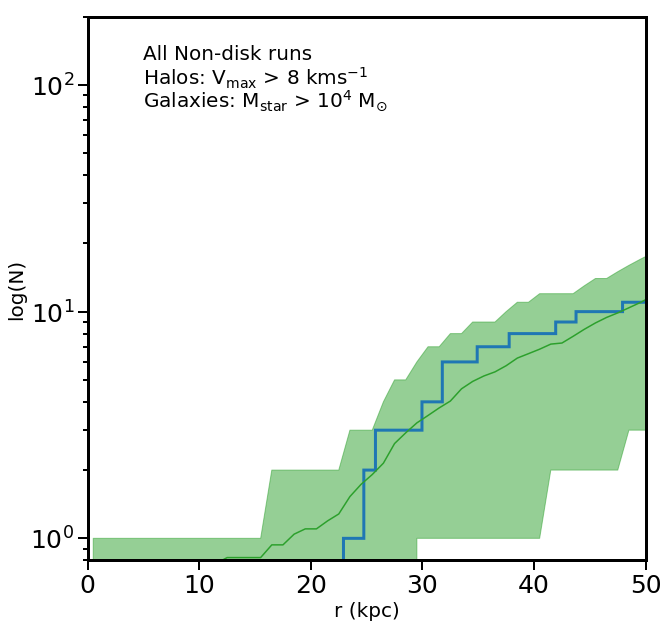

In [34]:
total_len = 0
total_hist = None

for data_file in os.listdir('../initial_test_with_ELVIS/Tyler_disk_data/'):
    f_halos = np.loadtxt('../initial_test_with_ELVIS/Tyler_disk_data/'+data_file)
    halo_name = re.split('_|\.',str(data_file))[2]
    Data_M = f_halos[:,3]
    Data_X = f_halos[:,0]/h
    Data_Y = f_halos[:,1]/h
    Data_Z = f_halos[:,2]/h
    Data_Rvir = f_halos[:,5]/h
    Data_Mass = f_halos[:,4]/h
    
    M_t = 8.0
    
    Vmax_mask = (Data_M>8.0)
    
    Data_X_cut = Data_X[Vmax_mask]
    Data_Y_cut = Data_Y[Vmax_mask]
    Data_Z_cut = Data_Z[Vmax_mask]
    Data_M_cut = Data_M[Vmax_mask]
    Data_Rvir_cut = Data_Rvir[Vmax_mask]
    
    host_index = np.argmax(Data_M_cut)
    R_vir_host = Data_Rvir_cut[host_index]
    
    Andr = 0
    MW = host_index

    hist_matrix = calc_corr_factors(Data_X_cut, Data_Y_cut, Data_Z_cut, Data_M_cut, Data_Rvir_cut, pnts, MW, Andr)
        
    if total_hist == None:
        total_hist = hist_matrix
    else:
        print shape(total_hist), shape(hist_matrix)
        total_hist = np.concatenate((total_hist,hist_matrix),axis=0)
    
    total_len += len(hist_matrix)
    
print total_len
print shape(total_hist)
        

plot_bins = [(radius_bins[ii]+radius_bins[ii+1])*1000.0/2.0 for ii in range(len(radius_bins)-1)]

min_line = [np.min(total_hist[:,ii]) for ii in range(len(total_hist[0]))]
max_line = [np.max(total_hist[:,ii]) for ii in range(len(total_hist[0]))]
med_line = [np.mean(total_hist[:,ii]) for ii in range(len(total_hist[0]))]

hl_line = [high_low_limit(total_hist[:,ii],0.68) for ii in range(len(total_hist[0]))]

low_line = [xx[0] for xx in hl_line]
high_line = [xx[1] for xx in hl_line]

plot_top = max_line[-1]

#print distances_within_cones[:,0], stacked_distance_array_fast[:,0]

f_dat = np.loadtxt('../Sats_data.csv',delimiter=',',dtype=object)
gal_dist = np.asarray([float(xx) for xx in f_dat[:,1]])
gal_mass = np.asarray([float(xx) for xx in f_dat[:,2]])

large_gal_mask = (gal_mass>1.0e4)&(gal_dist<R_vir_host)

large_gal_dist = gal_dist[large_gal_mask]
#print large_gal_dist

plt.figure(1,(10,10))
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)
plt.xlim([0.0,50.0])
plt.ylim([0.8,200.0])
plt.xlabel('r (kpc)',fontsize=20)
plt.ylabel('log(N)',fontsize=20)
plt.yscale('log')

plt.text(5.0,130.0,'All Non-disk runs',fontsize=20)
plt.text(5.0,100.0,'Halos: $V_{max}$ > 8 $kms^{-1}$',fontsize=20)
plt.text(5.0,80.0,'Galaxies: $M_{star}$ > $10^4$ $M_{\odot}$',fontsize=20)

plt.hist(gal_dist,bins=np.linspace(0.0,R_vir_host,1000),cumulative=True,histtype='step',linewidth=3)

plt.fill_between(plot_bins,low_line,high_line,color='C2',alpha=0.5)
plt.plot(plot_bins,med_line,color='C2')

#plt.yscale('log')
#plt.legend(loc=1, prop={'size': 20})
#plt.savefig('./initial_figures/non_disk_'+str(halo_name)+'.png',bbox_inches='tight')
plt.show()

1107
1245
1386
493


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:37: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


539
609
694
795
833
848
879
988
1200
(1200, 100)


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:91: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


1200
(1200, 100)


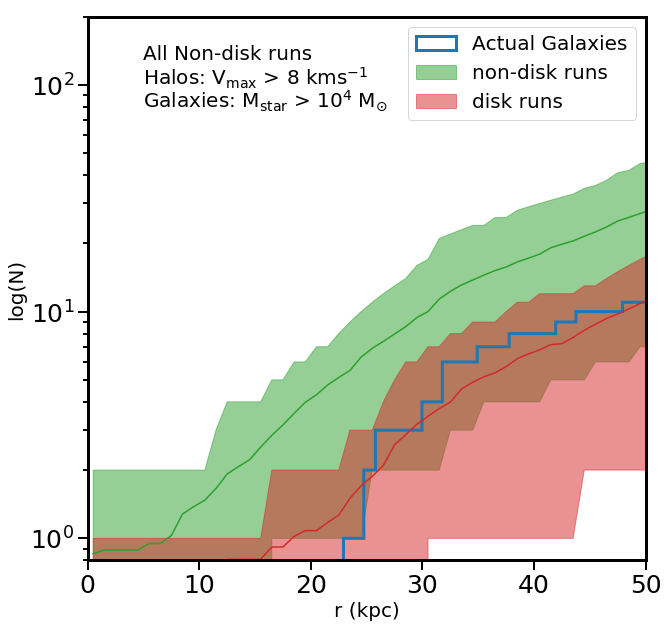

In [35]:
total_len = 0
total_hist = None

disk_total_len = 0
disk_total_hist = None

for data_file in os.listdir('../initial_test_with_ELVIS/Tyler_Data/'):
    f_halos = h5py.File('../initial_test_with_ELVIS/Tyler_Data/'+data_file)
    halo_name = data_file.split('_')[2]
    print halo_name
    Data_M = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Vmax'][:]
    Data_Mass = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Mvir'][:]/h
    Data_cens = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Center'][:]/h
    Data_X = Data_cens[:,0]
    Data_Y = Data_cens[:,1]
    Data_Z = Data_cens[:,2]
    Data_Rvir = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Rvir'][:]/h
    
    M_t = 8.0
    
    Vmax_mask = (Data_M>8.0)
    
    Data_X_cut = Data_X[Vmax_mask]
    Data_Y_cut = Data_Y[Vmax_mask]
    Data_Z_cut = Data_Z[Vmax_mask]
    Data_M_cut = Data_M[Vmax_mask]
    Data_Rvir_cut = Data_Rvir[Vmax_mask]
    
    host_index = np.argmax(Data_M_cut)
    R_vir_host = Data_Rvir_cut[host_index]
    
    Andr = 0
    MW = host_index

    hist_matrix = calc_corr_factors(Data_X_cut, Data_Y_cut, Data_Z_cut, Data_M_cut, Data_Rvir_cut, pnts, MW, Andr)
        
    if total_hist == None:
        total_hist = hist_matrix
    else:
        total_hist = np.concatenate((total_hist,hist_matrix),axis=0)
    
    total_len += len(hist_matrix)
    
print total_len
print shape(total_hist)
        

plot_bins = [(radius_bins[ii]+radius_bins[ii+1])*1000.0/2.0 for ii in range(len(radius_bins)-1)]

min_line = [np.min(total_hist[:,ii]) for ii in range(len(total_hist[0]))]
max_line = [np.max(total_hist[:,ii]) for ii in range(len(total_hist[0]))]
med_line = [np.mean(total_hist[:,ii]) for ii in range(len(total_hist[0]))]

hl_line = [high_low_limit(total_hist[:,ii],0.68) for ii in range(len(total_hist[0]))]

low_line = [xx[0] for xx in hl_line]
high_line = [xx[1] for xx in hl_line]

plot_top = max_line[-1]

# Now do the same for the disk runs

for data_file in os.listdir('../initial_test_with_ELVIS/Tyler_disk_data/'):
    f_halos = np.loadtxt('../initial_test_with_ELVIS/Tyler_disk_data/'+data_file)
    halo_name = re.split('_|\.',str(data_file))[2]
    Data_M = f_halos[:,3]
    Data_X = f_halos[:,0]/h
    Data_Y = f_halos[:,1]/h
    Data_Z = f_halos[:,2]/h
    Data_Rvir = f_halos[:,5]/h
    Data_Mass = f_halos[:,4]/h
    
    M_t = 8.0
    
    Vmax_mask = (Data_M>8.0)
    
    Data_X_cut = Data_X[Vmax_mask]
    Data_Y_cut = Data_Y[Vmax_mask]
    Data_Z_cut = Data_Z[Vmax_mask]
    Data_M_cut = Data_M[Vmax_mask]
    Data_Rvir_cut = Data_Rvir[Vmax_mask]
    
    host_index = np.argmax(Data_M_cut)
    R_vir_host = Data_Rvir_cut[host_index]
    
    Andr = 0
    MW = host_index

    hist_matrix = calc_corr_factors(Data_X_cut, Data_Y_cut, Data_Z_cut, Data_M_cut, Data_Rvir_cut, pnts, MW, Andr)
        
    if disk_total_hist == None:
        disk_total_hist = hist_matrix
    else:
        disk_total_hist = np.concatenate((disk_total_hist,hist_matrix),axis=0)
    
    disk_total_len += len(hist_matrix)
    
print disk_total_len
print shape(disk_total_hist)

disk_min_line = [np.min(disk_total_hist[:,ii]) for ii in range(len(disk_total_hist[0]))]
disk_max_line = [np.max(disk_total_hist[:,ii]) for ii in range(len(disk_total_hist[0]))]
disk_med_line = [np.mean(disk_total_hist[:,ii]) for ii in range(len(disk_total_hist[0]))]

disk_hl_line = [high_low_limit(disk_total_hist[:,ii],0.68) for ii in range(len(disk_total_hist[0]))]

disk_low_line = [xx[0] for xx in disk_hl_line]
disk_high_line = [xx[1] for xx in disk_hl_line]


f_dat = np.loadtxt('../Sats_data.csv',delimiter=',',dtype=object)
gal_dist = np.asarray([float(xx) for xx in f_dat[:,1]])
gal_mass = np.asarray([float(xx) for xx in f_dat[:,2]])

large_gal_mask = (gal_mass>1.0e4)&(gal_dist<R_vir_host)

large_gal_dist = gal_dist[large_gal_mask]
#print large_gal_dist

plt.figure(1,(10,10))
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)
plt.xlim([0.0,50.0])
plt.ylim([0.8,200.0])
plt.xlabel('r (kpc)',fontsize=20)
plt.ylabel('log(N)',fontsize=20)
plt.yscale('log')

plt.text(5.0,130.0,'All Non-disk runs',fontsize=20)
plt.text(5.0,100.0,'Halos: $V_{max}$ > 8 $kms^{-1}$',fontsize=20)
plt.text(5.0,80.0,'Galaxies: $M_{star}$ > $10^4$ $M_{\odot}$',fontsize=20)

plt.hist(gal_dist,bins=np.linspace(0.0,R_vir_host,1000),cumulative=True,histtype='step',linewidth=3,label='Actual Galaxies')

plt.fill_between(plot_bins,low_line,high_line,color='C2',alpha=0.5,label='non-disk runs')
plt.plot(plot_bins,med_line,color='C2')

plt.fill_between(plot_bins,disk_low_line,disk_high_line,color='C3',alpha=0.5,label='disk runs')
plt.plot(plot_bins,disk_med_line,color='C3')

#plt.yscale('log')
plt.legend(loc=1, prop={'size': 20})
#plt.savefig('./initial_figures/non_disk_'+str(halo_name)+'.png',bbox_inches='tight')
plt.show()

['9.1', '9.5', '11.4', '9.0', '7.8', '9.4', '2.4', '10.5', '7.6', '4.6', '4.6', '3.7', '3.3', '3.7', '7.5', '7.9', '3.9', '3.4', '7.6', '6.7', '4.3', '6.9', '2.9', '4.9', '3.22', '8.6', '0.1', '2.7', '2.9', '14.0']
[15.761662348876781, 16.454482671904334, 19.7453792062852, 15.588457268119894, 13.509996299037242, 16.281277591147447, 4.1569219381653051, 18.186533479473212, 13.163586137523467, 7.9674337148168348, 7.9674337148168348, 6.4085879880048457, 5.7157676649772942, 6.4085879880048457, 12.990381056766578, 13.683201379794131, 6.7549981495186211, 5.8889727457341827, 13.163586137523467, 11.604740410711477, 7.4478184725461718, 11.951150572225254, 5.0229473419497435, 8.4870489570874987, 5.5772036003717851, 14.895636945092344, 0.17320508075688773, 4.676537180435969, 5.0229473419497435, 24.248711305964282]


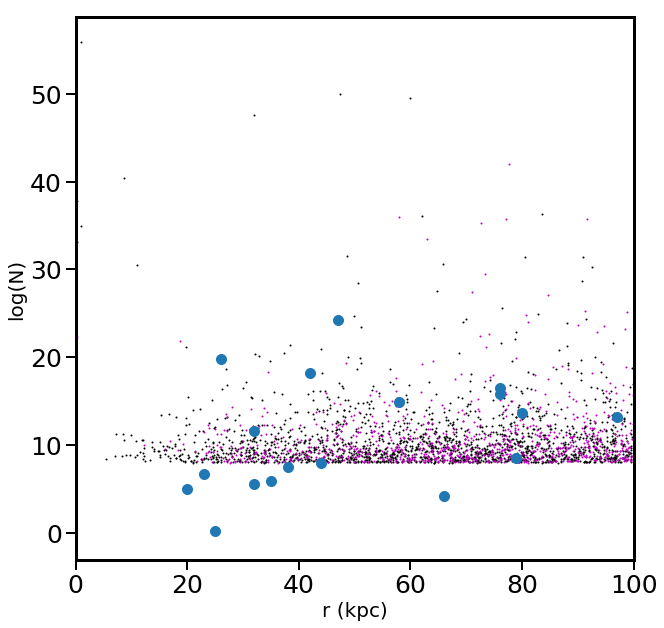

In [45]:
h = 0.6751

plt.figure(1,(10,10))
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)
plt.xlim([0.0,100.0])
#plt.ylim([0.8,200.0])
plt.xlabel('r (kpc)',fontsize=20)
plt.ylabel('log(N)',fontsize=20)

for data_file in os.listdir('../../initial_test_with_ELVIS/Tyler_Data/'):
    f_halos = h5py.File('../../initial_test_with_ELVIS/Tyler_Data/'+data_file)
    halo_name = data_file.split('_')[2]
    Data_M = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Vmax'][:]
    Data_Mass = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Mvir'][:]/h
    Data_cens = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Center'][:]*1000.0/h
    Data_X = Data_cens[:,0]
    Data_Y = Data_cens[:,1]
    Data_Z = Data_cens[:,2]
    Data_Rvir = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Rvir'][:]/h
    
    M_t = 8.0
    
    Vmax_mask = (Data_M>8.0)
    
    Data_X_cut = Data_X[Vmax_mask]
    Data_Y_cut = Data_Y[Vmax_mask]
    Data_Z_cut = Data_Z[Vmax_mask]
    Data_M_cut = Data_M[Vmax_mask]
    Data_Rvir_cut = Data_Rvir[Vmax_mask]
    
    host_index = np.argmax(Data_M_cut)
    R_vir_host = Data_Rvir_cut[host_index]
    
    MW = host_index
    
    z0_cens = np.vstack([Data_X_cut,Data_Y_cut,Data_Z_cut]).T
    
    coord_dist = z0_cens - z0_cens[host_index]
    distances_from_center = np.linalg.norm(coord_dist,axis=1)
    
    dist_mask = (distances_from_center<100.0)&(distances_from_center>0.0)
    
    dist_list = distances_from_center[dist_mask]
    mass_list = Data_M_cut[dist_mask]
    
    plt.scatter(dist_list,mass_list,color='k',s=1)
    

for data_file in os.listdir('../../initial_test_with_ELVIS/Tyler_disk_data/'):
    f_halos = np.loadtxt('../../initial_test_with_ELVIS/Tyler_disk_data/'+data_file)
    halo_name = re.split('_|\.',str(data_file))[2]
    Data_M = f_halos[:,3]
    Data_X = f_halos[:,0]*1000.0/h
    Data_Y = f_halos[:,1]*1000.0/h
    Data_Z = f_halos[:,2]*1000.0/h
    Data_Rvir = f_halos[:,5]/h
    Data_Mass = f_halos[:,4]/h
    
    M_t = 8.0
    
    Vmax_mask = (Data_M>8.0)
    
    Data_X_cut = Data_X[Vmax_mask]
    Data_Y_cut = Data_Y[Vmax_mask]
    Data_Z_cut = Data_Z[Vmax_mask]
    Data_M_cut = Data_M[Vmax_mask]
    Data_Rvir_cut = Data_Rvir[Vmax_mask]
    
    host_index = np.argmax(Data_M_cut)
    R_vir_host = Data_Rvir_cut[host_index]
    
    MW = host_index
    
    z0_cens = np.vstack([Data_X_cut,Data_Y_cut,Data_Z_cut]).T
    
    coord_dist = z0_cens - z0_cens[host_index]
    distances_from_center = np.linalg.norm(coord_dist,axis=1)
    
    dist_mask = (distances_from_center<100.0)&(distances_from_center>0.0)
    
    dist_list = distances_from_center[dist_mask]
    mass_list = Data_M_cut[dist_mask]
    
    plt.scatter(dist_list,mass_list,color='m',s=1)
    
f_dat_vdisp = np.loadtxt('../../Sats_data_vdisp.csv',delimiter=',',dtype=object)

dist = f_dat_vdisp[:,1]
v_disp = f_dat_vdisp[:,5]
v_disp_low = f_dat_vdisp[:,6]
v_disp_high = f_dat_vdisp[:,7]

dist_filter = [dist[xx] for xx in range(len(dist)) if v_disp[xx]!='' ]

v_list = filter(None,v_disp)
v_list_low = filter(None,v_disp_low)
v_list_high = filter(None,v_disp_high)

V_c_list = [sqrt(3.0)*float(jj) for jj in v_list]

print v_list

print V_c_list

plt.figure(1,(10,10))
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)
plt.xlim([0.0,100.0])
#plt.ylim([0.8,200.0])
plt.xlabel('r (kpc)',fontsize=20)
plt.ylabel('log(N)',fontsize=20)

plt.scatter(dist_filter,V_c_list,s=100,color='C0')

#plt.yscale('log')
plt.legend(loc=1, prop={'size': 20})
#plt.savefig('./initial_figures/non_disk_'+str(halo_name)+'.png',bbox_inches='tight')
plt.show()

['9.1', '9.5', '11.4', '9.0', '7.8', '9.4', '2.4', '10.5', '7.6', '4.6', '4.6', '3.7', '3.3', '3.7', '7.5', '7.9', '3.9', '3.4', '7.6', '6.7', '4.3', '6.9', '2.9', '4.9', '3.22', '8.6', '0.1', '2.7', '2.9', '14.0']
[15.761662348876781, 16.454482671904334, 19.7453792062852, 15.588457268119894, 13.509996299037242, 16.281277591147447, 4.1569219381653051, 18.186533479473212, 13.163586137523467, 7.9674337148168348, 7.9674337148168348, 6.4085879880048457, 5.7157676649772942, 6.4085879880048457, 12.990381056766578, 13.683201379794131, 6.7549981495186211, 5.8889727457341827, 13.163586137523467, 11.604740410711477, 7.4478184725461718, 11.951150572225254, 5.0229473419497435, 8.4870489570874987, 5.5772036003717851, 14.895636945092344, 0.17320508075688773, 4.676537180435969, 5.0229473419497435, 24.248711305964282]
1107 (non disk)
[u'Atotal', u'BulkVelocity', u'BulkVelocityUncertainty', u'Center', u'E', u'ID', u'J', u'Mboundvir', u'Mvir', u'PositionUncertainty', u'Rmax', u'Rs', u'Rs_Klypin', u'Rvir

/usr/local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


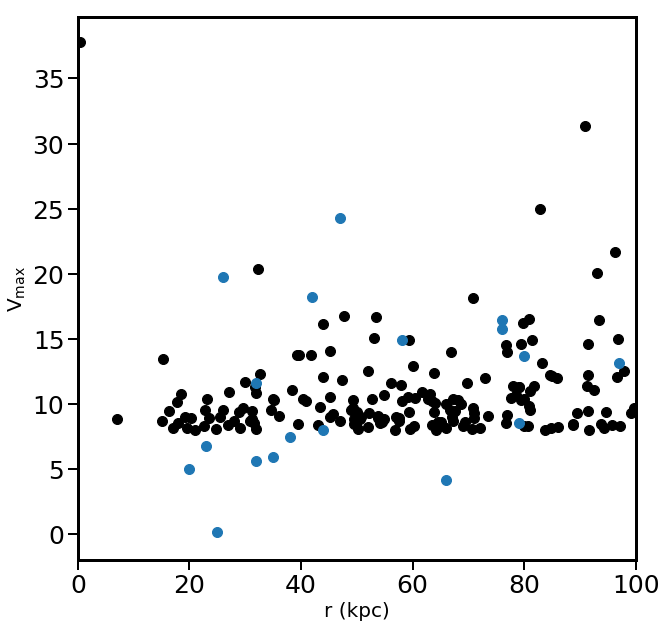

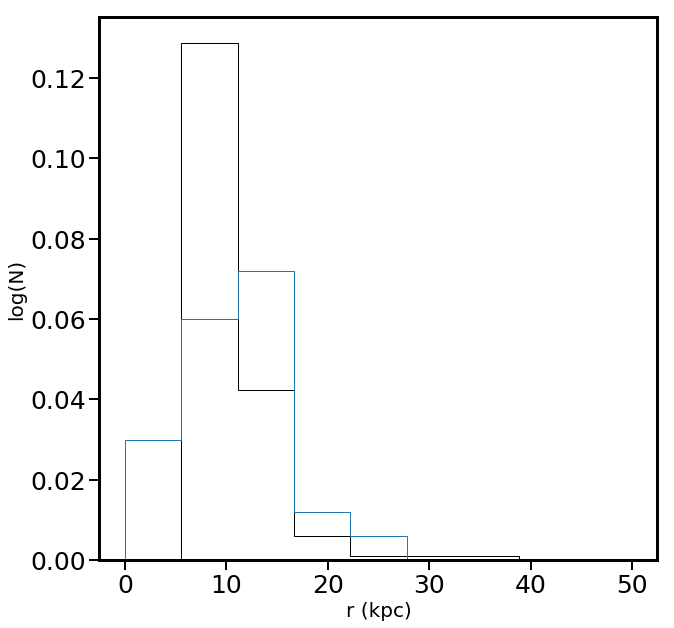

1245 (non disk)
[u'Atotal', u'BulkVelocity', u'BulkVelocityUncertainty', u'Center', u'E', u'ID', u'J', u'Mboundvir', u'Mvir', u'PositionUncertainty', u'Rmax', u'Rs', u'Rs_Klypin', u'Rvir', u'Spin', u'T_over_U', u'Velocity', u'VelocityUncertainty', u'Vmax', u'Voff', u'Xoff', u'b_to_a', u'c_to_a', u'i_ph', u'i_so', u'idx', u'm200b', u'm200c', u'm2500c', u'm500c', u'mmetric', u'n_core', u'npart', u'num_cp', u'spin_bullock', u'vrms']


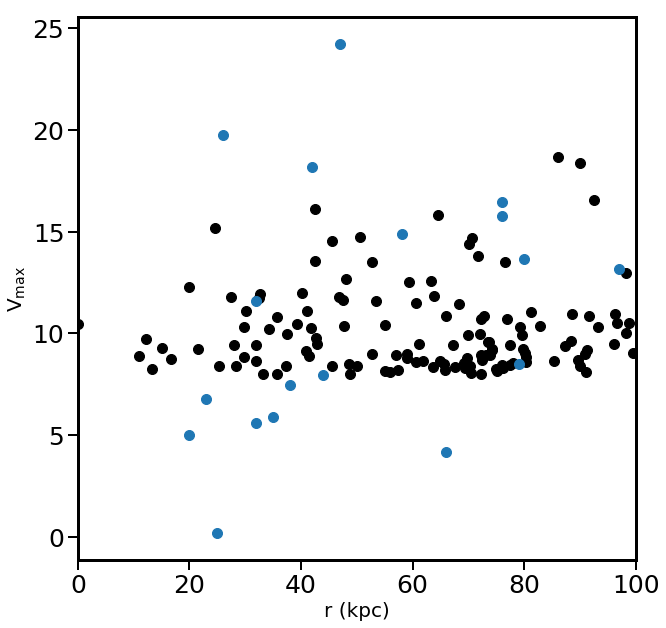

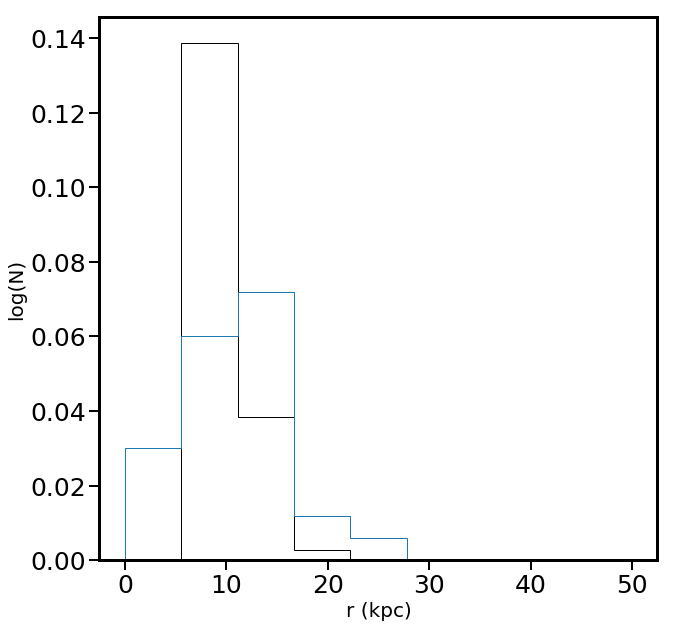

1386 (non disk)
[u'Atotal', u'BulkVelocity', u'BulkVelocityUncertainty', u'Center', u'E', u'ID', u'J', u'Mboundvir', u'Mvir', u'PositionUncertainty', u'Rmax', u'Rs', u'Rs_Klypin', u'Rvir', u'Spin', u'T_over_U', u'Velocity', u'VelocityUncertainty', u'Vmax', u'Voff', u'Xoff', u'b_to_a', u'c_to_a', u'i_ph', u'i_so', u'idx', u'm200b', u'm200c', u'm2500c', u'm500c', u'mmetric', u'n_core', u'npart', u'num_cp', u'spin_bullock', u'vrms']


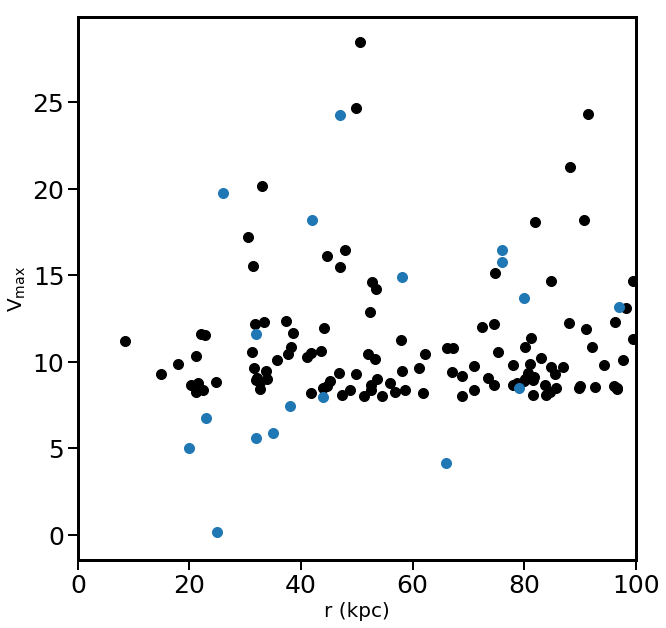

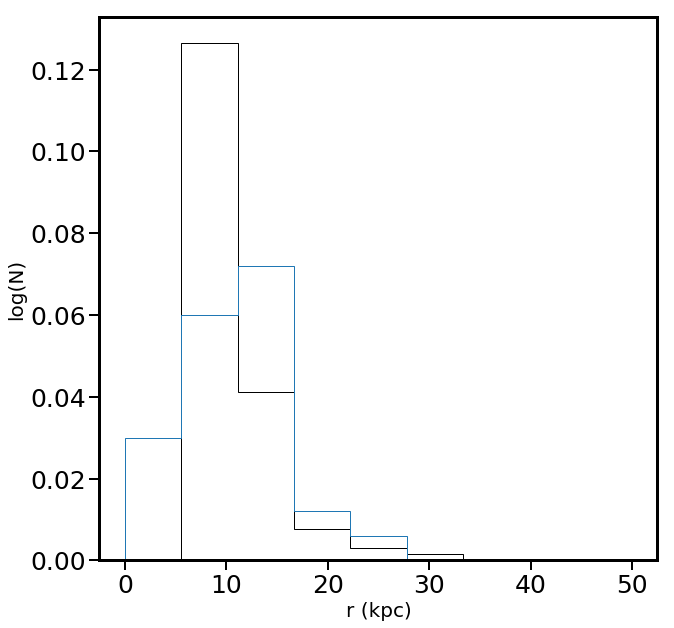

493 (non disk)
[u'Atotal', u'BulkVelocity', u'BulkVelocityUncertainty', u'Center', u'E', u'ID', u'J', u'Mboundvir', u'Mvir', u'PositionUncertainty', u'Rmax', u'Rs', u'Rs_Klypin', u'Rvir', u'Spin', u'T_over_U', u'Velocity', u'VelocityUncertainty', u'Vmax', u'Voff', u'Xoff', u'b_to_a', u'c_to_a', u'i_ph', u'i_so', u'idx', u'm200b', u'm200c', u'm2500c', u'm500c', u'mmetric', u'n_core', u'npart', u'num_cp', u'spin_bullock', u'vrms']


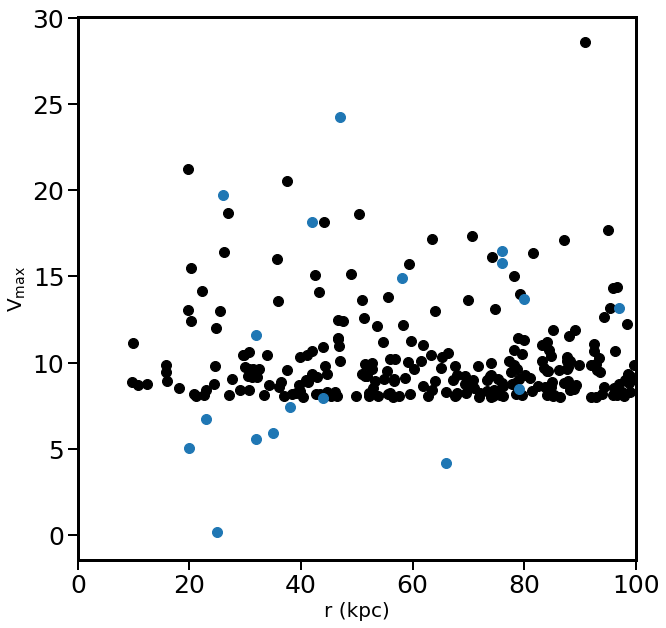

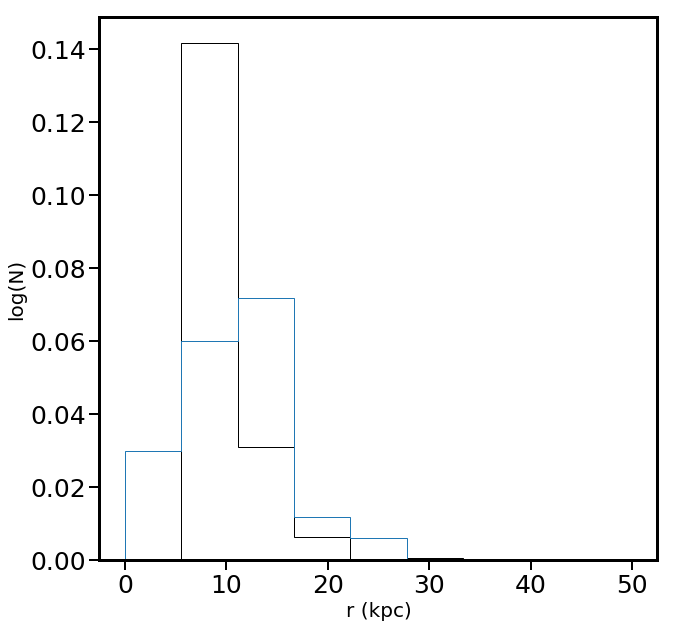

539 (non disk)
[u'Atotal', u'BulkVelocity', u'BulkVelocityUncertainty', u'Center', u'E', u'ID', u'J', u'Mboundvir', u'Mvir', u'PositionUncertainty', u'Rmax', u'Rs', u'Rs_Klypin', u'Rvir', u'Spin', u'T_over_U', u'Velocity', u'VelocityUncertainty', u'Vmax', u'Voff', u'Xoff', u'b_to_a', u'c_to_a', u'i_ph', u'i_so', u'idx', u'm200b', u'm200c', u'm2500c', u'm500c', u'mmetric', u'n_core', u'npart', u'num_cp', u'spin_bullock', u'vrms']


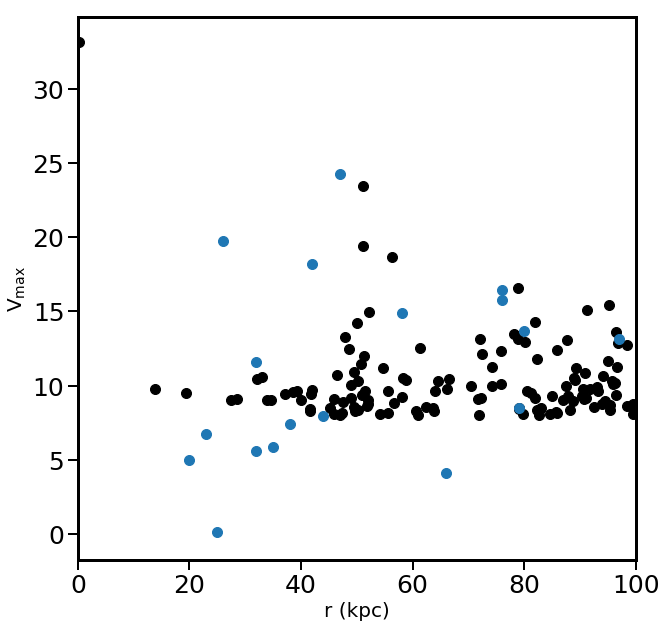

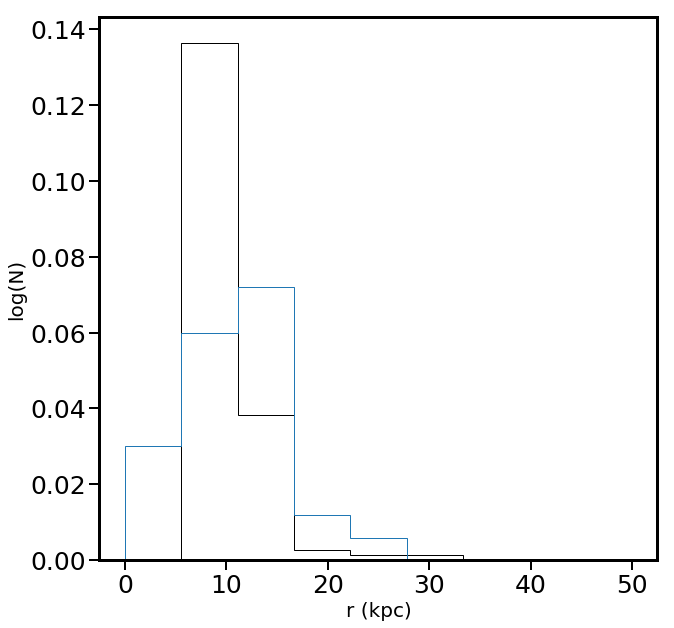

609 (non disk)
[u'Atotal', u'BulkVelocity', u'BulkVelocityUncertainty', u'Center', u'E', u'ID', u'J', u'Mboundvir', u'Mvir', u'PositionUncertainty', u'Rmax', u'Rs', u'Rs_Klypin', u'Rvir', u'Spin', u'T_over_U', u'Velocity', u'VelocityUncertainty', u'Vmax', u'Voff', u'Xoff', u'b_to_a', u'c_to_a', u'i_ph', u'i_so', u'idx', u'm200b', u'm200c', u'm2500c', u'm500c', u'mmetric', u'n_core', u'npart', u'num_cp', u'spin_bullock', u'vrms']


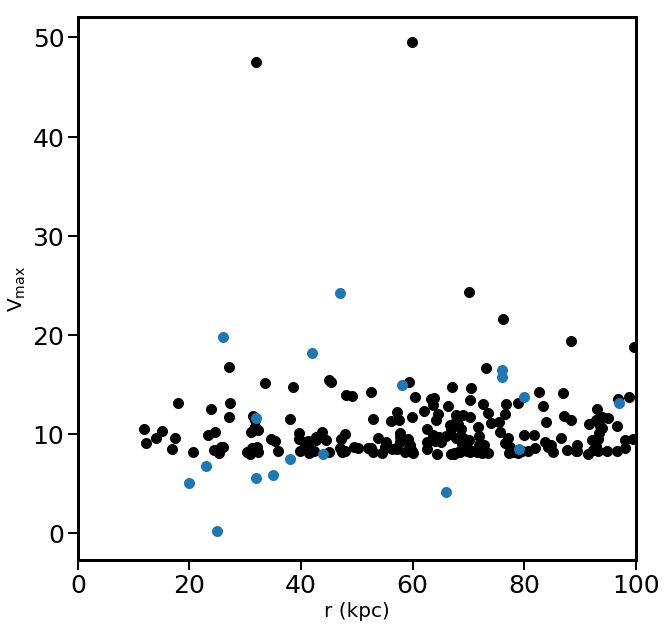

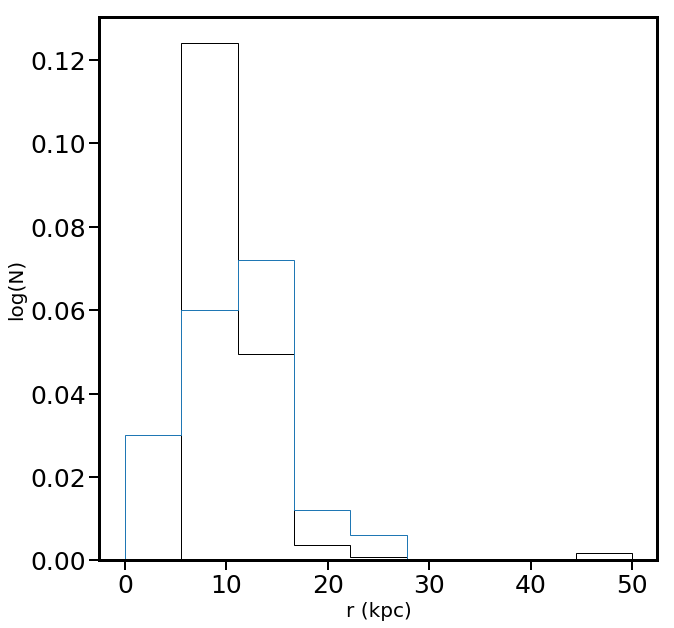

694 (non disk)
[u'Atotal', u'BulkVelocity', u'BulkVelocityUncertainty', u'Center', u'E', u'ID', u'J', u'Mboundvir', u'Mvir', u'PositionUncertainty', u'Rmax', u'Rs', u'Rs_Klypin', u'Rvir', u'Spin', u'T_over_U', u'Velocity', u'VelocityUncertainty', u'Vmax', u'Voff', u'Xoff', u'b_to_a', u'c_to_a', u'i_ph', u'i_so', u'idx', u'm200b', u'm200c', u'm2500c', u'm500c', u'mmetric', u'n_core', u'npart', u'num_cp', u'spin_bullock', u'vrms']


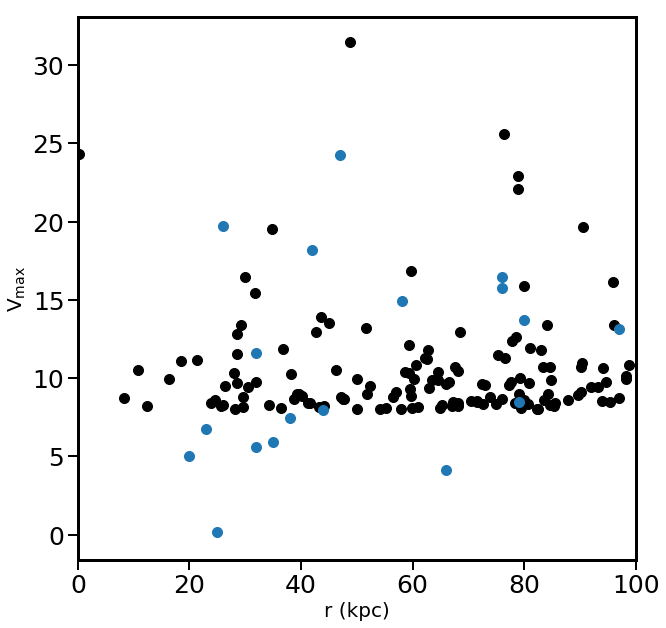

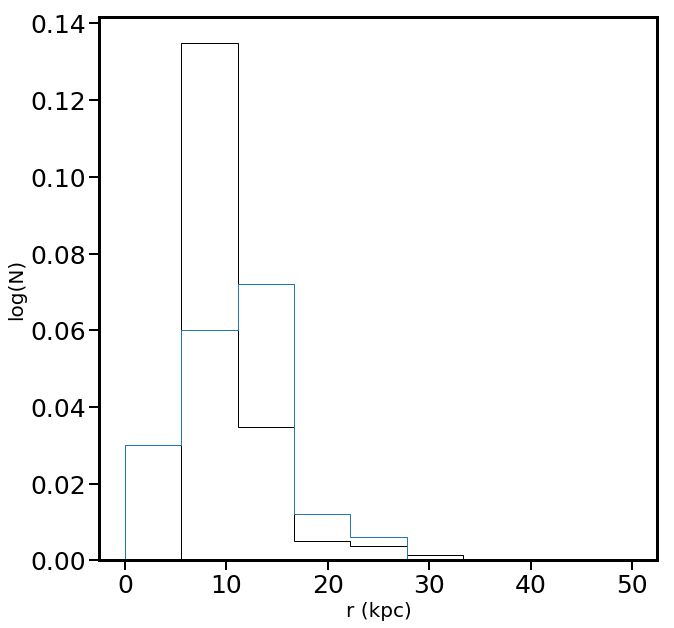

795 (non disk)
[u'Atotal', u'BulkVelocity', u'BulkVelocityUncertainty', u'Center', u'E', u'ID', u'J', u'Mboundvir', u'Mvir', u'PositionUncertainty', u'Rmax', u'Rs', u'Rs_Klypin', u'Rvir', u'Spin', u'T_over_U', u'Velocity', u'VelocityUncertainty', u'Vmax', u'Voff', u'Xoff', u'b_to_a', u'c_to_a', u'i_ph', u'i_so', u'idx', u'm200b', u'm200c', u'm2500c', u'm500c', u'mmetric', u'n_core', u'npart', u'num_cp', u'spin_bullock', u'vrms']


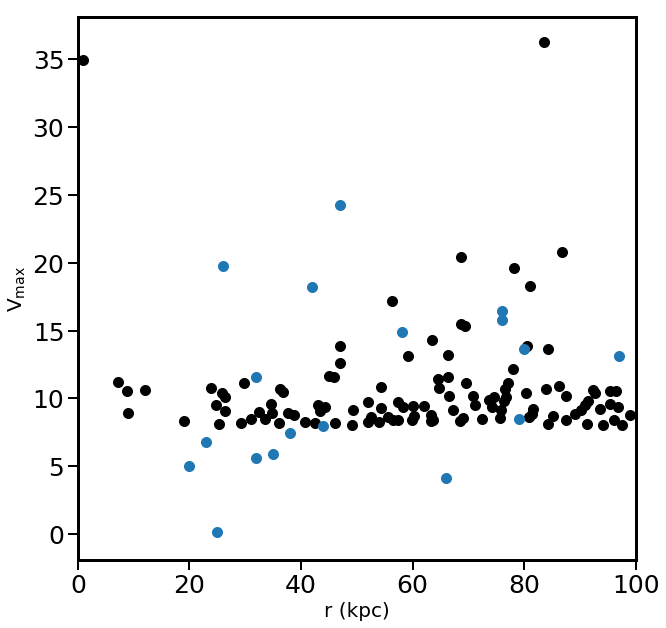

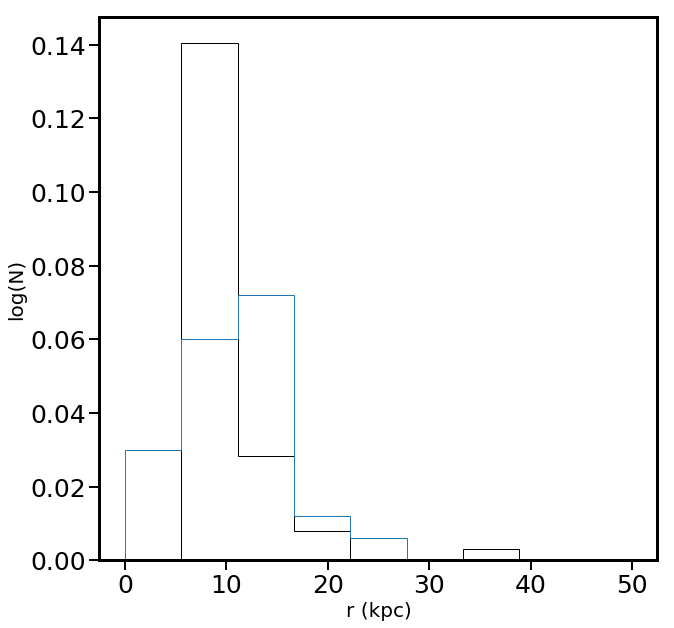

833 (non disk)
[u'Atotal', u'BulkVelocity', u'BulkVelocityUncertainty', u'Center', u'E', u'ID', u'J', u'Mboundvir', u'Mvir', u'PositionUncertainty', u'Rmax', u'Rs', u'Rs_Klypin', u'Rvir', u'Spin', u'T_over_U', u'Velocity', u'VelocityUncertainty', u'Vmax', u'Voff', u'Xoff', u'b_to_a', u'c_to_a', u'i_ph', u'i_so', u'idx', u'm200b', u'm200c', u'm2500c', u'm500c', u'mmetric', u'n_core', u'npart', u'num_cp', u'spin_bullock', u'vrms']


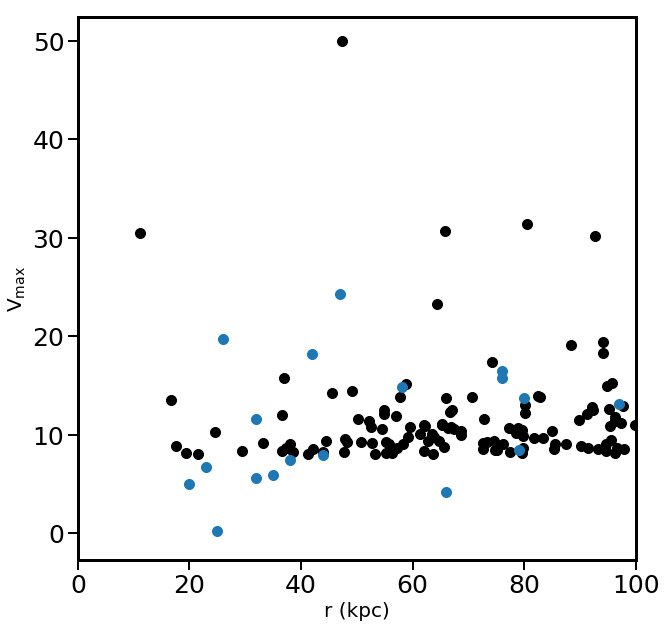

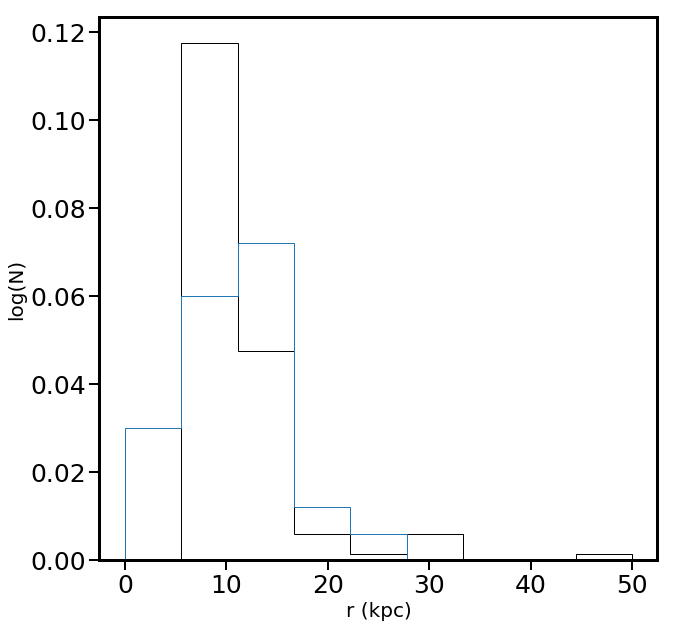

848 (non disk)
[u'Atotal', u'BulkVelocity', u'BulkVelocityUncertainty', u'Center', u'E', u'ID', u'J', u'Mboundvir', u'Mvir', u'PositionUncertainty', u'Rmax', u'Rs', u'Rs_Klypin', u'Rvir', u'Spin', u'T_over_U', u'Velocity', u'VelocityUncertainty', u'Vmax', u'Voff', u'Xoff', u'b_to_a', u'c_to_a', u'i_ph', u'i_so', u'idx', u'm200b', u'm200c', u'm2500c', u'm500c', u'mmetric', u'n_core', u'npart', u'num_cp', u'spin_bullock', u'vrms']


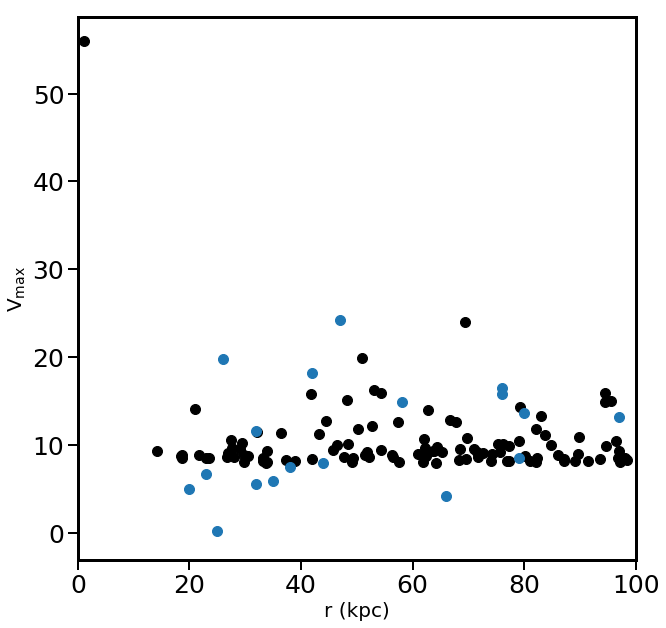

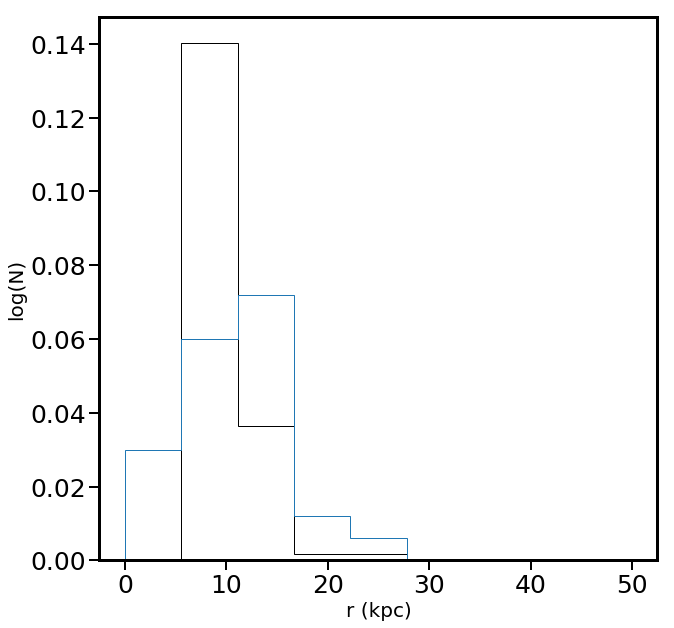

879 (non disk)
[u'Atotal', u'BulkVelocity', u'BulkVelocityUncertainty', u'Center', u'E', u'ID', u'J', u'Mboundvir', u'Mvir', u'PositionUncertainty', u'Rmax', u'Rs', u'Rs_Klypin', u'Rvir', u'Spin', u'T_over_U', u'Velocity', u'VelocityUncertainty', u'Vmax', u'Voff', u'Xoff', u'b_to_a', u'c_to_a', u'i_ph', u'i_so', u'idx', u'm200b', u'm200c', u'm2500c', u'm500c', u'mmetric', u'n_core', u'npart', u'num_cp', u'spin_bullock', u'vrms']


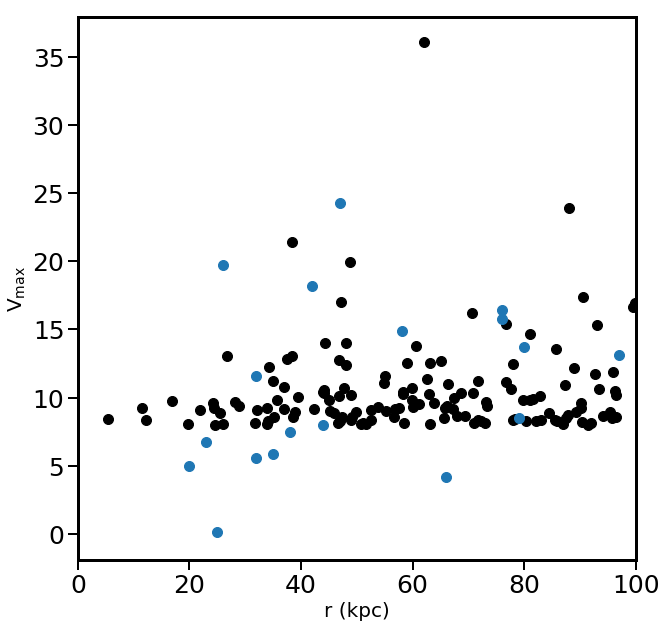

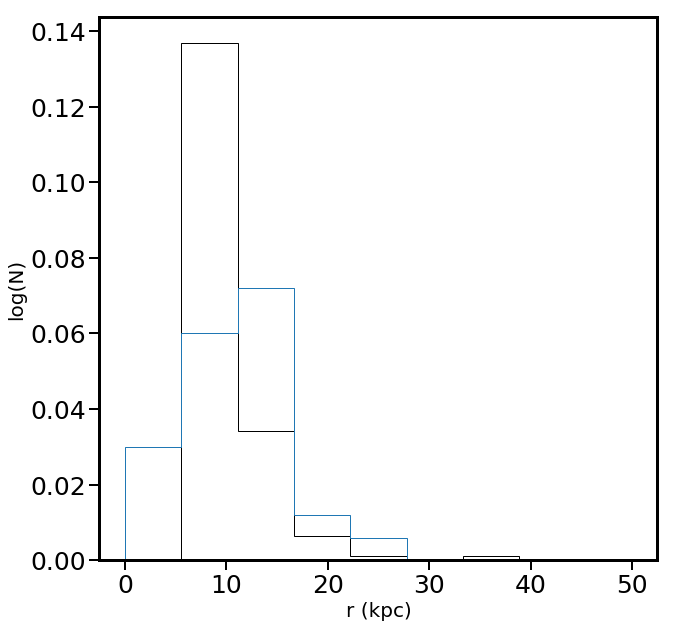

988 (non disk)
[u'Atotal', u'BulkVelocity', u'BulkVelocityUncertainty', u'Center', u'E', u'ID', u'J', u'Mboundvir', u'Mvir', u'PositionUncertainty', u'Rmax', u'Rs', u'Rs_Klypin', u'Rvir', u'Spin', u'T_over_U', u'Velocity', u'VelocityUncertainty', u'Vmax', u'Voff', u'Xoff', u'b_to_a', u'c_to_a', u'i_ph', u'i_so', u'idx', u'm200b', u'm200c', u'm2500c', u'm500c', u'mmetric', u'n_core', u'npart', u'num_cp', u'spin_bullock', u'vrms']


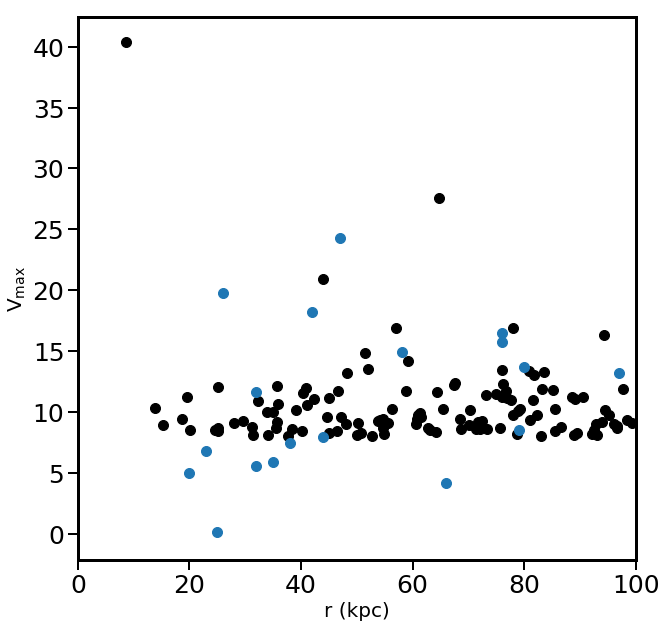

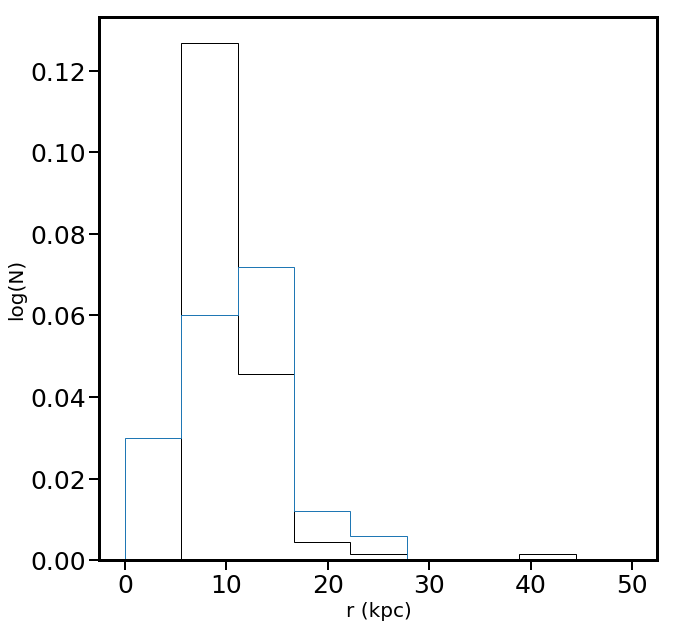

1107 (disk)


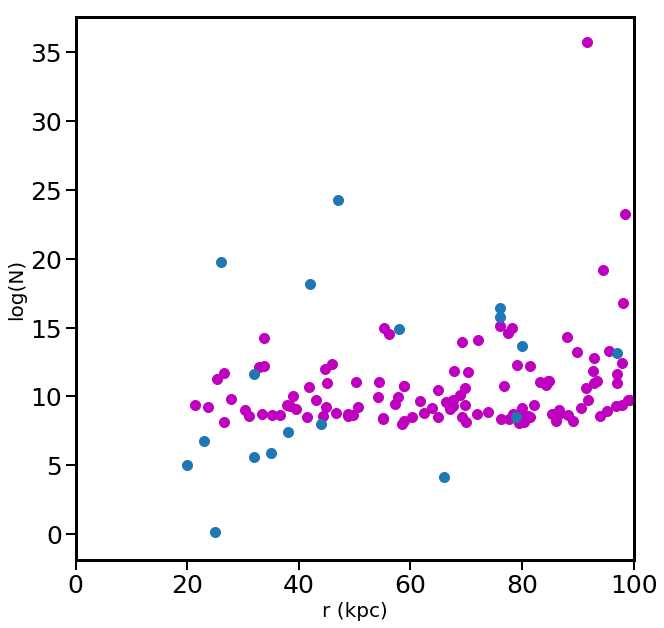

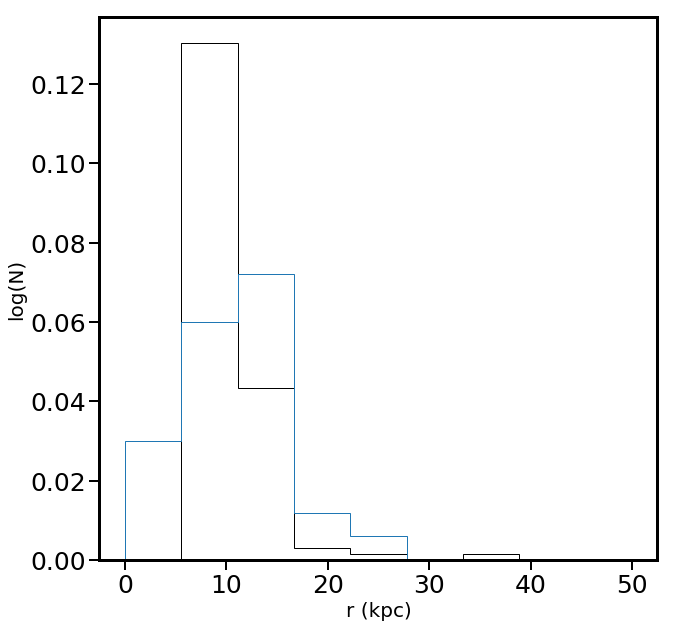

1245 (disk)


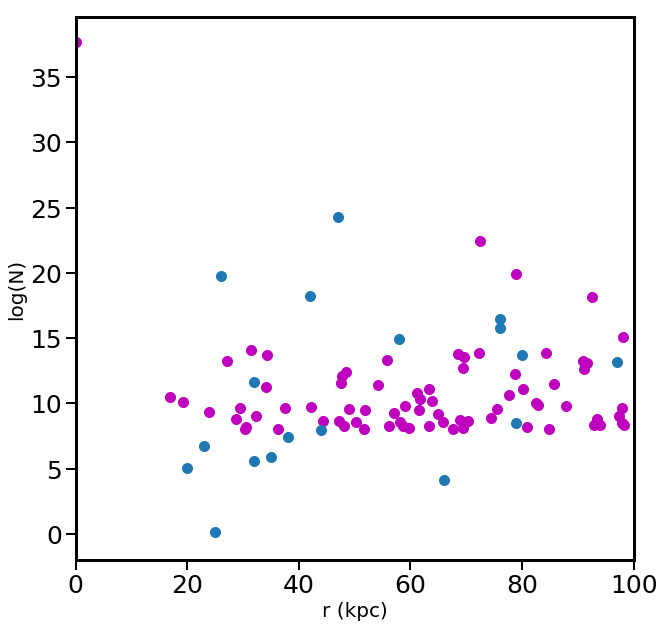

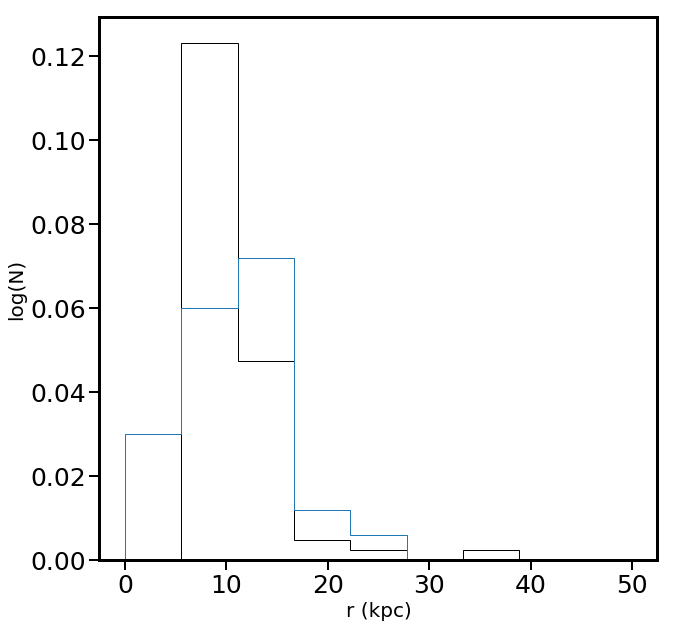

1386 (disk)


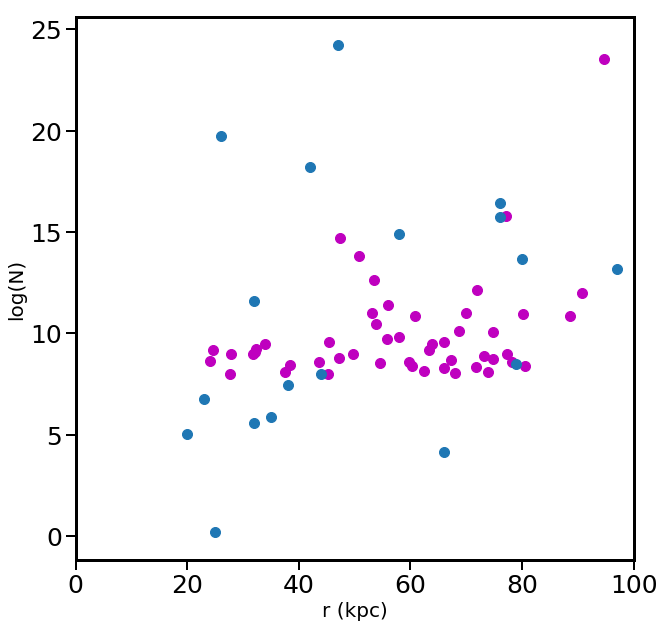

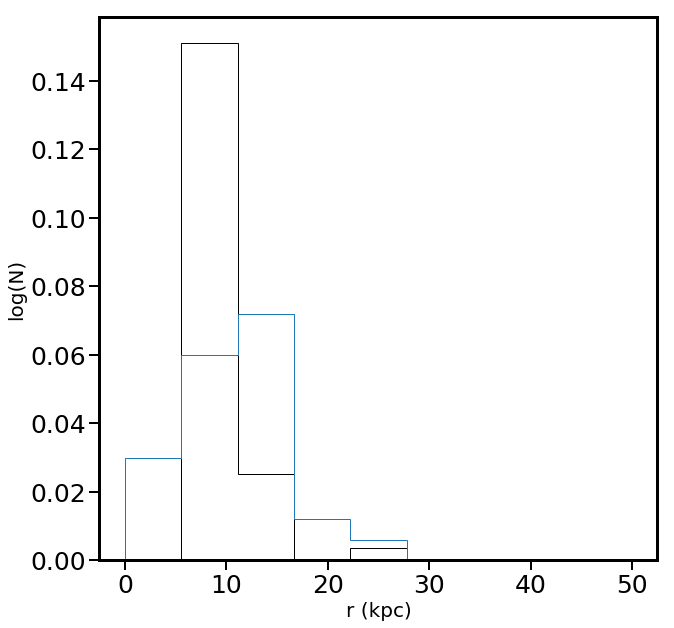

493 (disk)


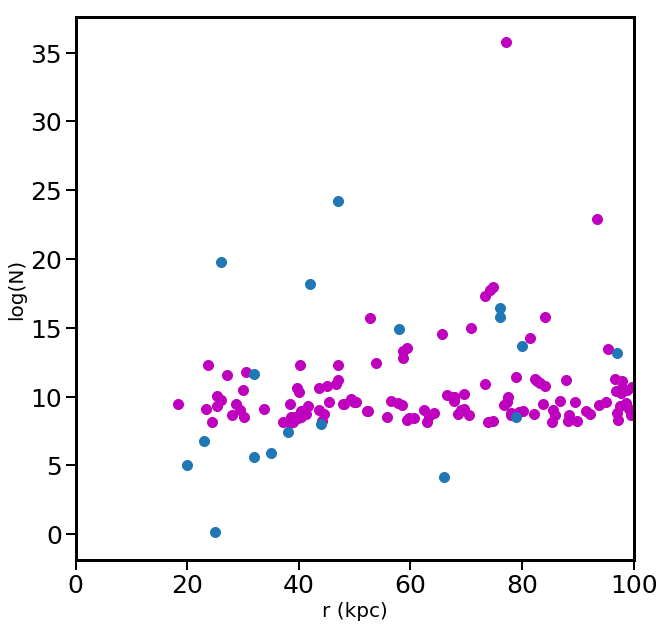

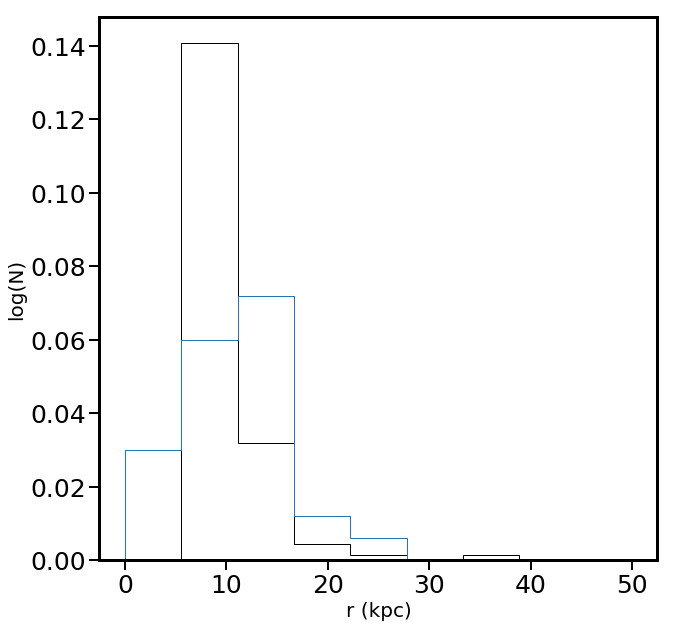

539 (disk)


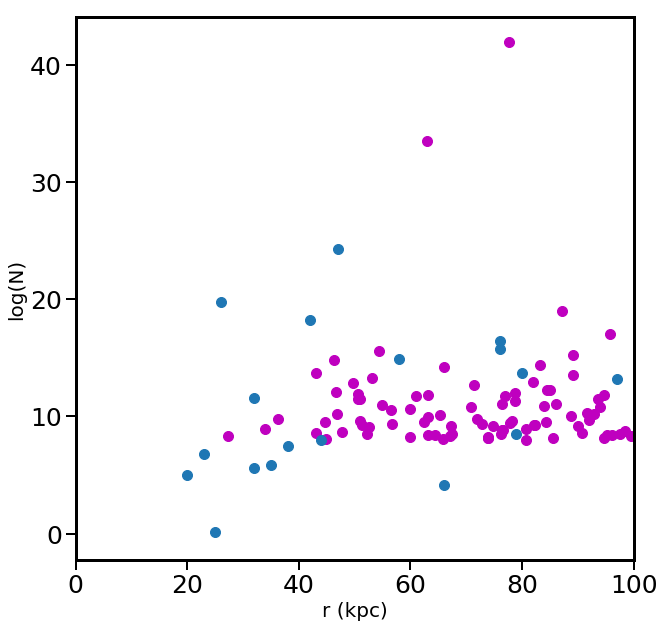

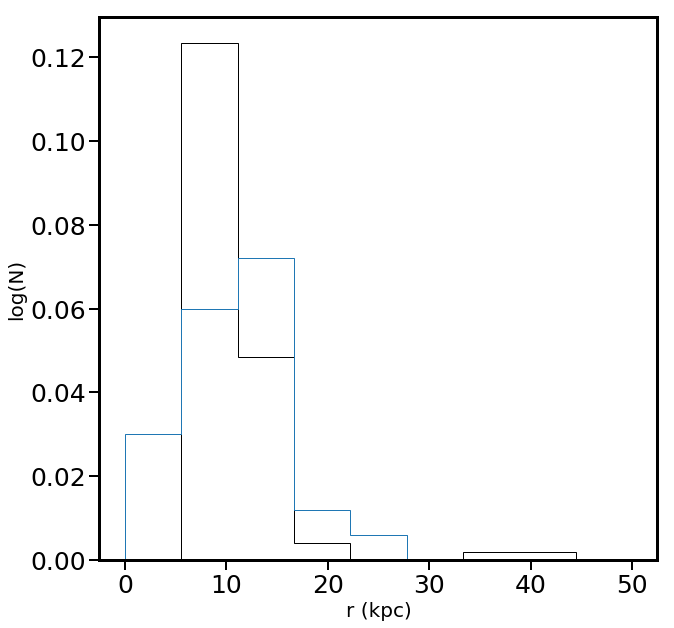

609 (disk)


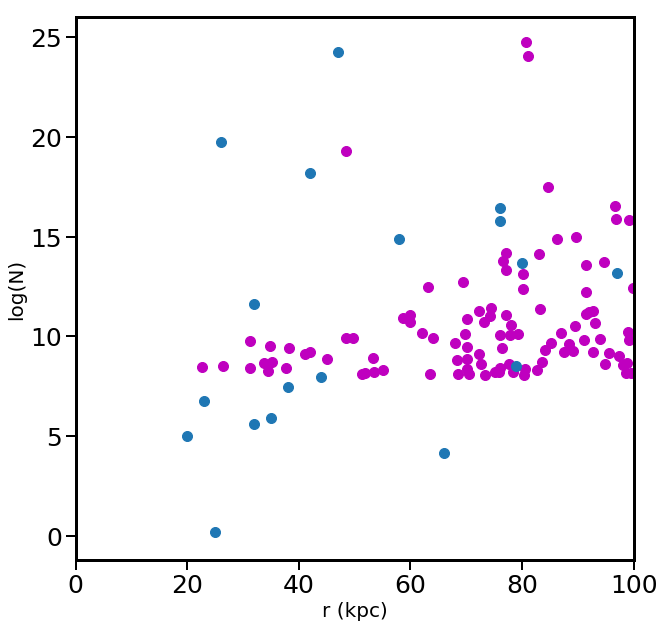

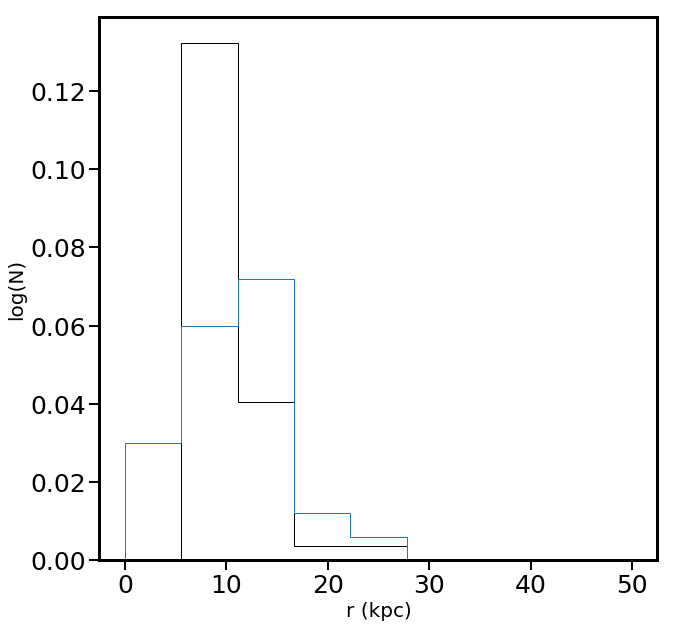

694 (disk)


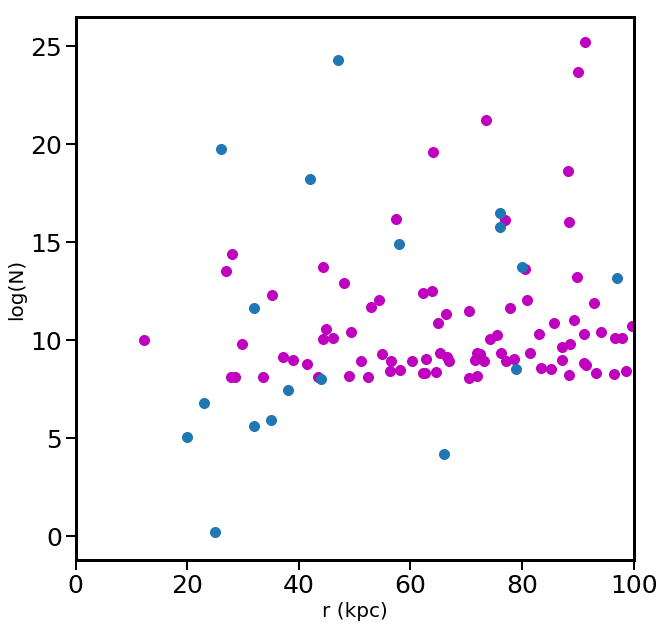

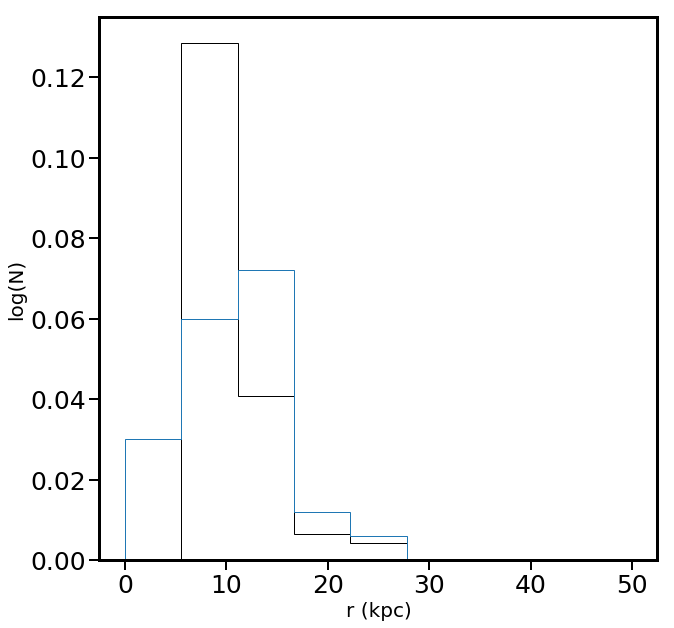

795 (disk)


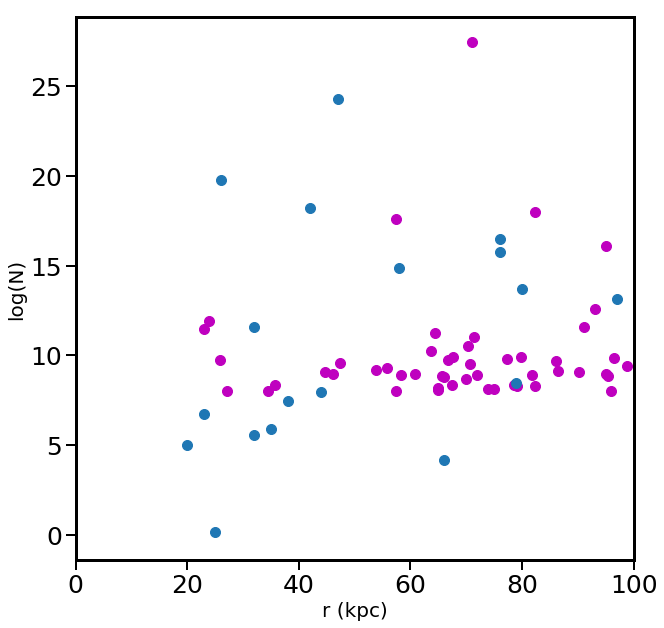

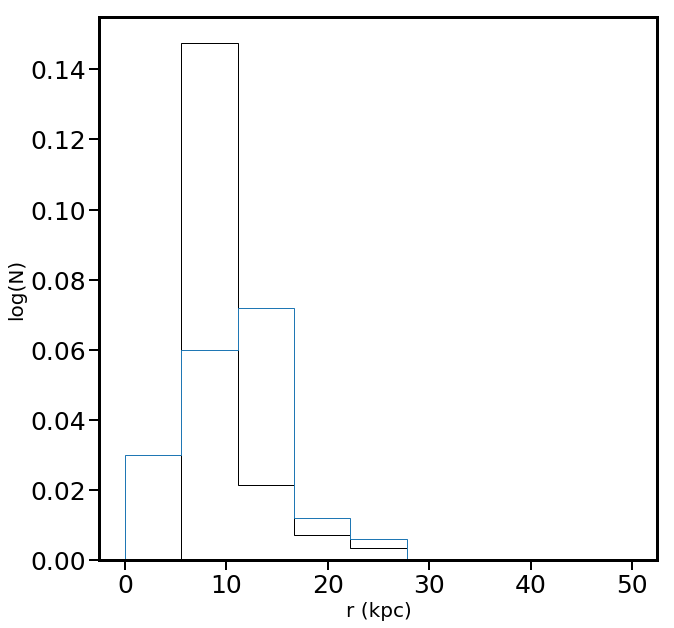

833 (disk)


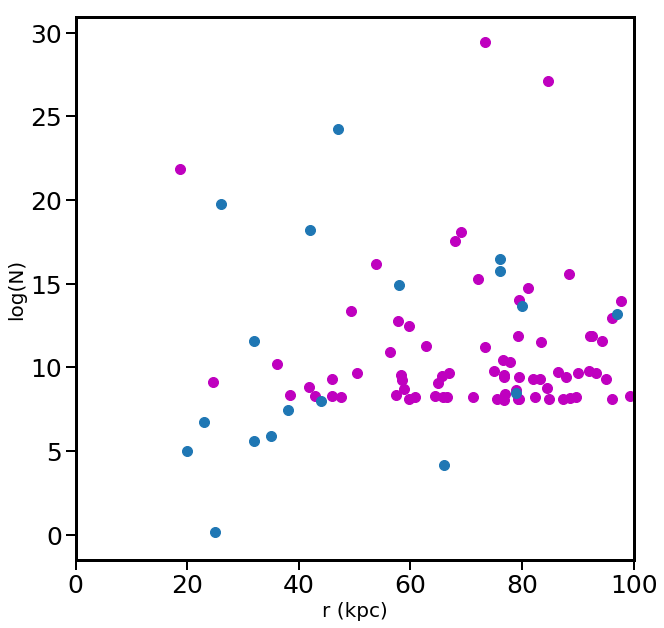

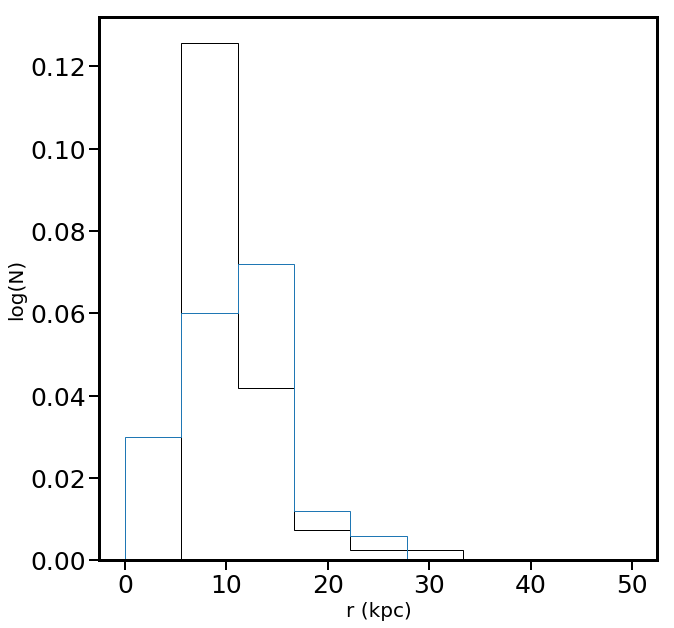

848 (disk)


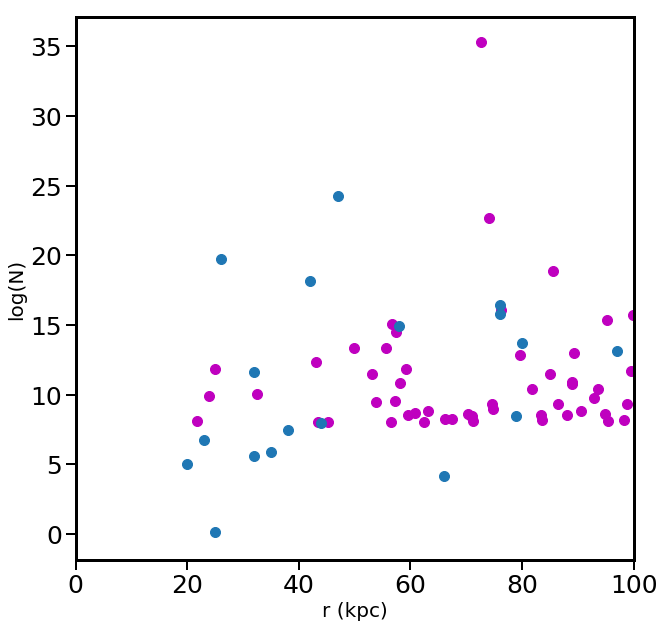

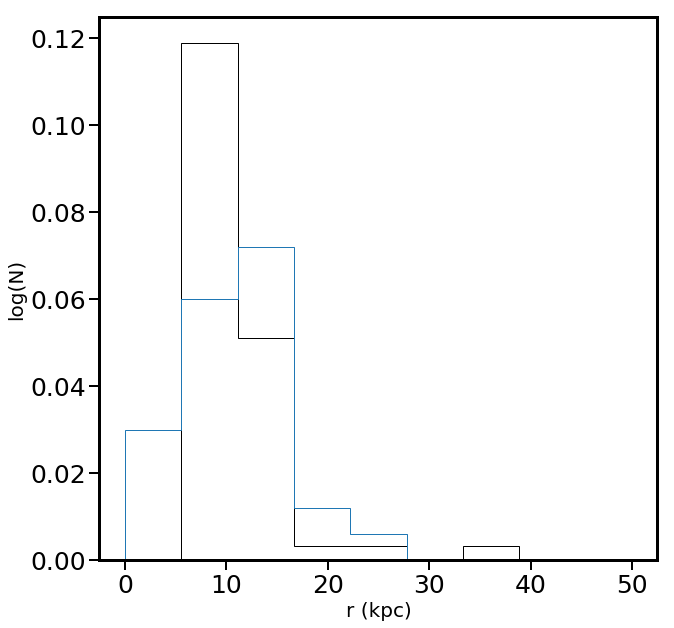

879 (disk)


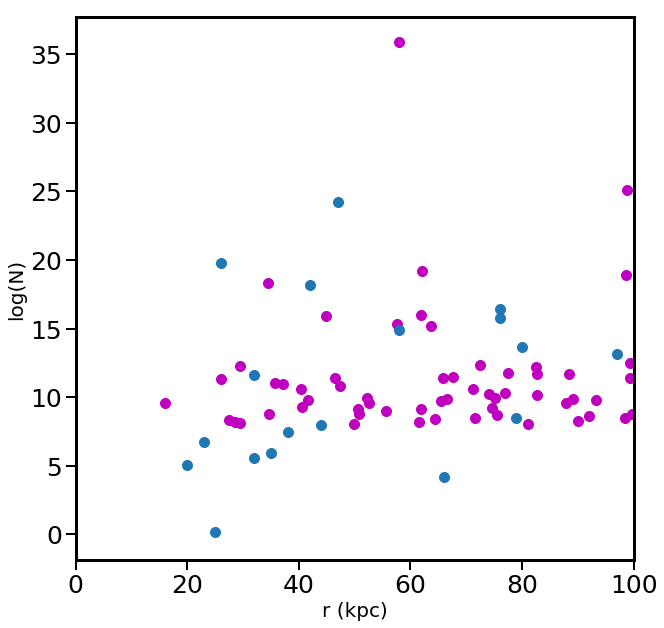

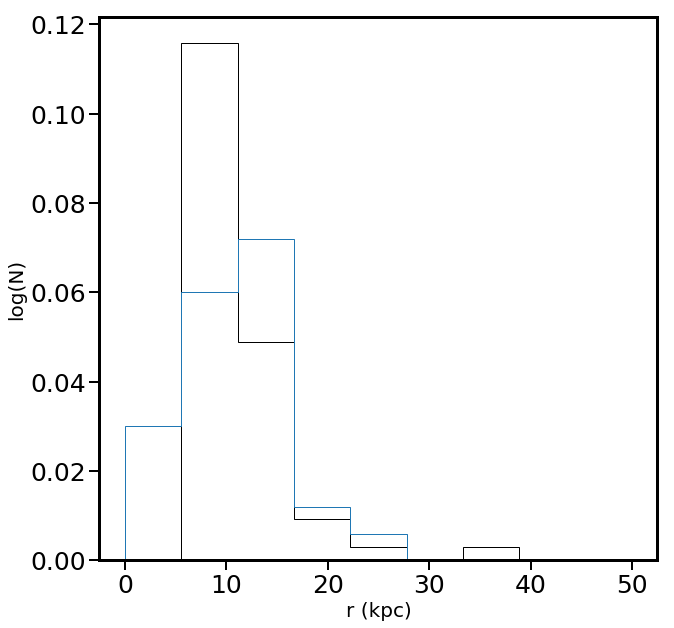

988 (disk)


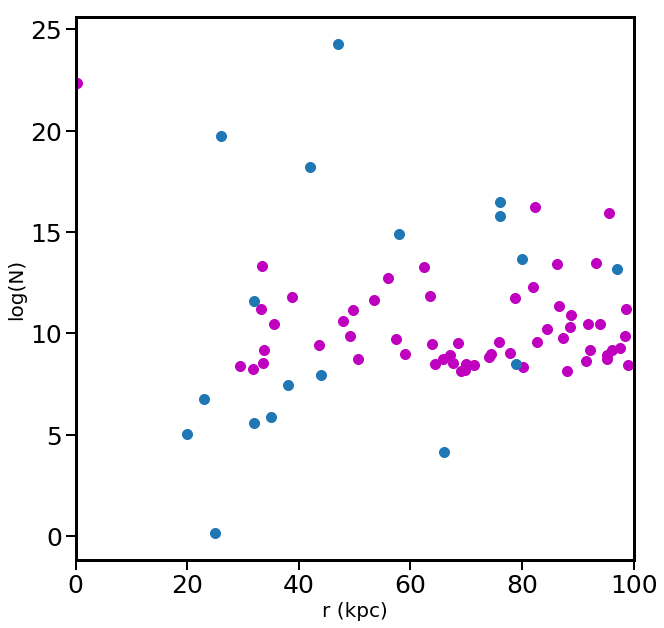

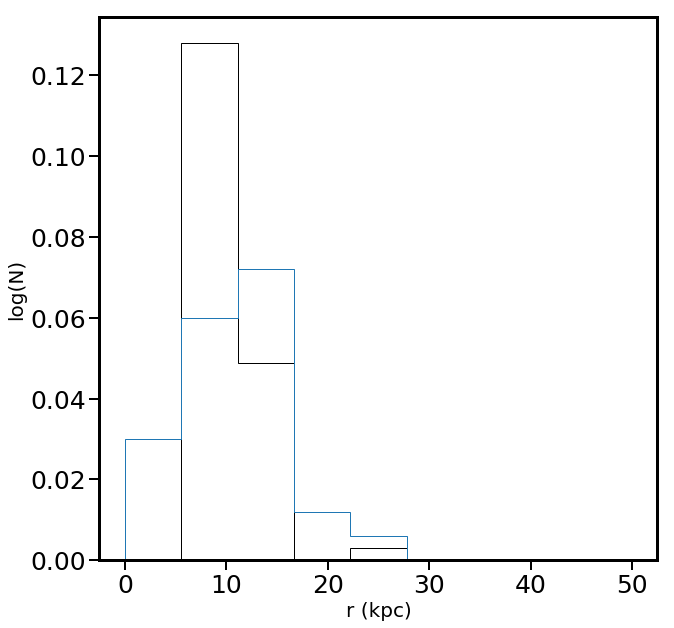

In [3]:
h = 0.6751

f_dat_vdisp = np.loadtxt('../../Sats_data_vdisp.csv',delimiter=',',dtype=object)

dist = f_dat_vdisp[:,1]
v_disp = f_dat_vdisp[:,5]
v_disp_low = f_dat_vdisp[:,6]
v_disp_high = f_dat_vdisp[:,7]

dist_filter = [dist[xx] for xx in range(len(dist)) if v_disp[xx]!='' ]

v_list = filter(None,v_disp)
v_list_low = filter(None,v_disp_low)
v_list_high = filter(None,v_disp_high)

V_c_list = [sqrt(3.0)*float(jj) for jj in v_list]

print v_list

print V_c_list

V_max_list = np.linspace(0.0,50.0,10)

for data_file in os.listdir('../../initial_test_with_ELVIS/Tyler_Data/'):
    f_halos = h5py.File('../../initial_test_with_ELVIS/Tyler_Data/'+data_file)
    halo_name = data_file.split('_')[2]
    
    print halo_name+' (non disk)'
    
    print f_halos['Snapshot00152']['HaloCatalog_Rockstar'].keys()
    
    Data_M = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Vmax'][:]
    Data_Mass = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Mvir'][:]/h
    Data_cens = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Center'][:]*1000.0/h
    Data_X = Data_cens[:,0]
    Data_Y = Data_cens[:,1]
    Data_Z = Data_cens[:,2]
    Data_Rvir = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Rvir'][:]/h
    
    M_t = 8.0
    
    Vmax_mask = (Data_M>8.0)
    
    Data_X_cut = Data_X[Vmax_mask]
    Data_Y_cut = Data_Y[Vmax_mask]
    Data_Z_cut = Data_Z[Vmax_mask]
    Data_M_cut = Data_M[Vmax_mask]
    Data_Rvir_cut = Data_Rvir[Vmax_mask]
    
    host_index = np.argmax(Data_M_cut)
    R_vir_host = Data_Rvir_cut[host_index]
    
    MW = host_index
    
    z0_cens = np.vstack([Data_X_cut,Data_Y_cut,Data_Z_cut]).T
    
    coord_dist = z0_cens - z0_cens[host_index]
    distances_from_center = np.linalg.norm(coord_dist,axis=1)
    
    dist_mask = (distances_from_center<100.0)&(distances_from_center>0.0)
    
    dist_list = distances_from_center[dist_mask]
    mass_list = Data_M_cut[dist_mask]
    
    plt.figure(1,(10,10))
    rc('axes',linewidth=3)
    plt.yticks(fontsize = 25)
    plt.xticks(fontsize = 25)
    plt.tick_params(which='minor',width=2,length=5)
    plt.tick_params(which='major',width=2,length=10)
    plt.xlim([0.0,100.0])
    #plt.ylim([0.8,200.0])
    plt.xlabel('r (kpc)',fontsize=20)
    plt.ylabel('$V_{max}$',fontsize=20)
    
    plt.scatter(dist_list,mass_list,color='k',s=100)
    plt.scatter(dist_filter,V_c_list,s=100,color='C0')

    #plt.yscale('log')
    plt.legend(loc=1, prop={'size': 20})
    #plt.savefig('./initial_figures/non_disk_'+str(halo_name)+'.png',bbox_inches='tight')
    plt.show()
    
    plt.figure(2,(10,10))
    rc('axes',linewidth=3)
    plt.yticks(fontsize = 25)
    plt.xticks(fontsize = 25)
    plt.tick_params(which='minor',width=2,length=5)
    plt.tick_params(which='major',width=2,length=10)
    #plt.xlim([0.0,100.0])
    #plt.ylim([0.8,200.0])
    plt.xlabel('r (kpc)',fontsize=20)
    plt.ylabel('log(N)',fontsize=20)
    
    plt.hist(mass_list,color='k',histtype='step',normed=True,bins=V_max_list)
    plt.hist(V_c_list,color='C0',histtype='step',normed=True,bins=V_max_list)

    plt.legend(loc=1, prop={'size': 20})
    plt.show()
    
for data_file in os.listdir('../../initial_test_with_ELVIS/Tyler_disk_data/'):
    f_halos = np.loadtxt('../../initial_test_with_ELVIS/Tyler_disk_data/'+data_file)
    halo_name = re.split('_|\.',str(data_file))[2]
    
    print halo_name+' (disk)'
    
    Data_M = f_halos[:,3]
    Data_X = f_halos[:,0]*1000.0/h
    Data_Y = f_halos[:,1]*1000.0/h
    Data_Z = f_halos[:,2]*1000.0/h
    Data_Rvir = f_halos[:,5]/h
    Data_Mass = f_halos[:,4]/h
    
    M_t = 8.0
    
    Vmax_mask = (Data_M>8.0)
    
    Data_X_cut = Data_X[Vmax_mask]
    Data_Y_cut = Data_Y[Vmax_mask]
    Data_Z_cut = Data_Z[Vmax_mask]
    Data_M_cut = Data_M[Vmax_mask]
    Data_Rvir_cut = Data_Rvir[Vmax_mask]
    
    host_index = np.argmax(Data_M_cut)
    R_vir_host = Data_Rvir_cut[host_index]
    
    MW = host_index
    
    z0_cens = np.vstack([Data_X_cut,Data_Y_cut,Data_Z_cut]).T
    
    coord_dist = z0_cens - z0_cens[host_index]
    distances_from_center = np.linalg.norm(coord_dist,axis=1)
    
    dist_mask = (distances_from_center<100.0)&(distances_from_center>0.0)
    
    dist_list = distances_from_center[dist_mask]
    mass_list = Data_M_cut[dist_mask]
    
    plt.figure(1,(10,10))
    rc('axes',linewidth=3)
    plt.yticks(fontsize = 25)
    plt.xticks(fontsize = 25)
    plt.tick_params(which='minor',width=2,length=5)
    plt.tick_params(which='major',width=2,length=10)
    plt.xlim([0.0,100.0])
    #plt.ylim([0.8,200.0])
    plt.xlabel('r (kpc)',fontsize=20)
    plt.ylabel('log(N)',fontsize=20)
    
    plt.scatter(dist_list,mass_list,color='m',s=100)
    plt.scatter(dist_filter,V_c_list,s=100,color='C0')

    #plt.yscale('log')
    plt.legend(loc=1, prop={'size': 20})
    #plt.savefig('./initial_figures/non_disk_'+str(halo_name)+'.png',bbox_inches='tight')
    plt.show()
    
    plt.figure(2,(10,10))
    rc('axes',linewidth=3)
    plt.yticks(fontsize = 25)
    plt.xticks(fontsize = 25)
    plt.tick_params(which='minor',width=2,length=5)
    plt.tick_params(which='major',width=2,length=10)
    #plt.xlim([0.0,100.0])
    #plt.ylim([0.8,200.0])
    plt.xlabel('r (kpc)',fontsize=20)
    plt.ylabel('log(N)',fontsize=20)
    
    plt.hist(mass_list,color='k',histtype='step',normed=True,bins=V_max_list)
    plt.hist(V_c_list,color='C0',histtype='step',normed=True,bins=V_max_list)

    plt.legend(loc=1, prop={'size': 20})
    plt.show()

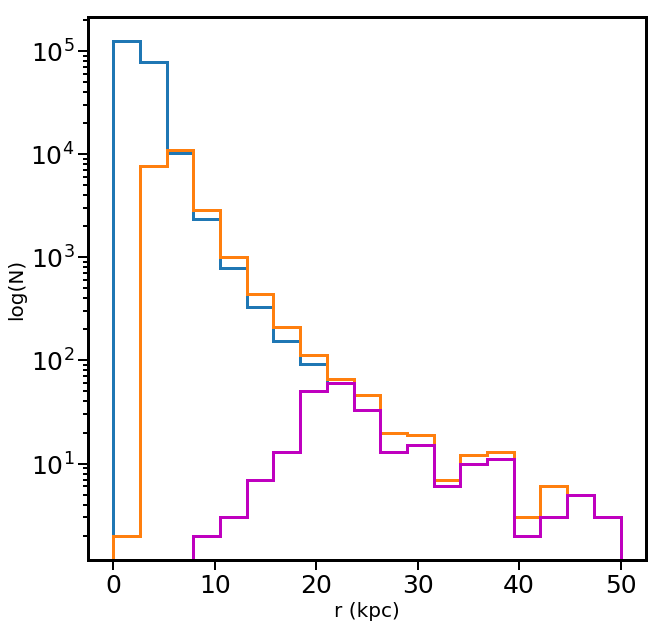

In [13]:
h = 0.6751

f_halos = np.loadtxt('../../initial_test_with_ELVIS/Tyler_disk_data_from_mt/reduced_data_1107_from_mt.txt')
Data_M = f_halos[:,3]
Data_X = f_halos[:,0]*1000.0/h
Data_Y = f_halos[:,1]*1000.0/h
Data_Z = f_halos[:,2]*1000.0/h
Data_Rvir = f_halos[:,5]/h
Data_Mass = f_halos[:,4]/h
Data_Vpeak = f_halos[:,6]

Vpeak_mask = (Data_Vpeak>20.0)

v_bins = np.linspace(0.0,50,20)
plt.figure(1,(10,10))
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)
#plt.xlim([0.0,100.0])
#plt.ylim([0.8,200.0])
plt.yscale('log')
plt.xlabel('r (kpc)',fontsize=20)
plt.ylabel('log(N)',fontsize=20)

plt.hist(Data_M,bins=v_bins,histtype='step',linewidth=3)
plt.hist(Data_Vpeak,bins=v_bins,histtype='step',linewidth=3)
plt.hist(Data_M[Vpeak_mask],bins=v_bins,histtype='step',color='m',linewidth=3)
plt.show()